In [1]:
import numpy as np, time, astropy.io.fits, os, sys
import healpy as hp
import matplotlib.pylab as plt

In [2]:


class JackKnifer(object):
    """
    Define the masks of the Jackknife giving the mask, number of patches and fraction of the sky you
    want to leave unmasked.
    Args:
        nside_jk (int): HEALPix resolution parameter defining
            the different jackknife regions.
        mask (array): sky mask.
        frac_thr (float): minimum fraction of a given jackknife region
            that must be unmasked for that region to be included in
            the set of regions.
    """
    def __init__(self, nside_jk, mask, frac_thr=0.8):
        # Total number of patches across the sky.
        npatch = hp.nside2npix(nside_jk)
        # Resolution of the maps.
        self.nside_maps = hp.npix2nside(len(mask))
        # Give each JK region an index.
        jk_ids = hp.ud_grade(np.arange(npatch),
                             nside_out=self.nside_maps).astype(int)
        # Number of pixels in each JK region.
        self.npix_per_patch = (self.nside_maps//nside_jk)**2
        ipix = np.arange(hp.nside2npix(self.nside_maps))

        # Loop through available regions and collect only the
        # unmasked ones.
        jk_pixels = []
        for ip in range(npatch):
            # Compute masked fraction.
            msk = jk_ids == ip
            frac = np.sum(mask[msk])/self.npix_per_patch
            if frac > frac_thr:  # If above threshold, take.
                jk_pixels.append(ipix[msk])
        self.jk_pixels = np.array(jk_pixels)
        # Total number of JK regions.
        self.npatches = len(self.jk_pixels)

    def get_mask_jk(self, jk_id):
        """
        Get mask associated with a given jackknife region.
        Args:
            jk_id (int): jackknife region index.
        """
        if jk_id >= self.npatches:
            raise ValueError("Asking for non-existent jackknife region")
        # Initially all ones, then zero all pixels in the region.
        msk = np.ones(hp.nside2npix(self.nside_maps))
        msk[self.jk_pixels[jk_id]] = 0
        return msk


Text(0.5, 1.0, 'fake mask')

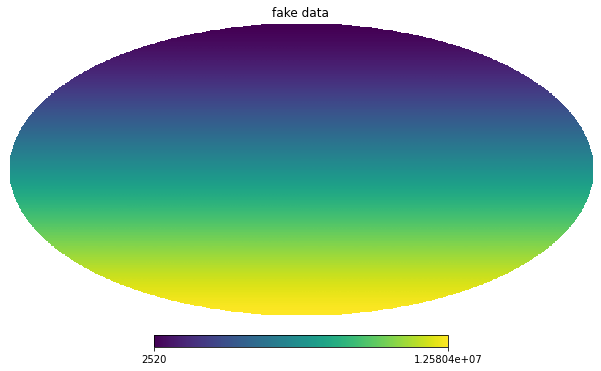

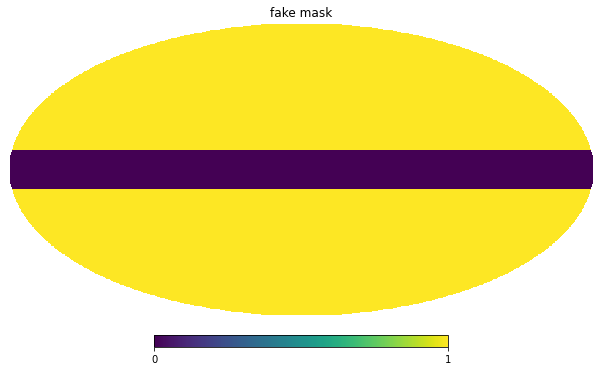

In [3]:
#Por exemplo, vou criar um mapa de nside = 512 e uma respectiva mascara aleatoria
nside = 1024
mapa = np.arange(hp.nside2npix(nside))
hp.mollview(mapa)
plt.title('fake data')

mask = np.zeros(hp.nside2npix(nside))
theta_cut = np.deg2rad(90. - 10)
mask[np.where((hp.pix2ang(nside, np.arange(mask.size) ))[0] >= (np.pi - theta_cut))] = 1.
mask[np.where((hp.pix2ang(nside, np.arange(mask.size) ))[0] <= theta_cut)] = 1.


hp.mollview(mask)
plt.title('fake mask')

# Define JK masks based on the number of patches you want to remove

In [4]:
nside_jk = 4 #this is the low-resolution nside to define the JK masks. QUanto menor o valor, maior sera sua mascara/menor o numero 
#total de patches a serem removidos
jk =  JackKnifer(nside_jk, mask, frac_thr= 0.8)
npatches = jk.npatches
print('total Jk patches are', npatches)


total Jk patches are 144


# Visualizar a area total a ser removida por iteracao:

/global/common/software/lsst/common/miniconda/dp-v0.0.42-d/lib/python3.8/site-packages/healpy/visufunc.py:200: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = pylab.figure(fig, figsize=(8.5, 5.4))


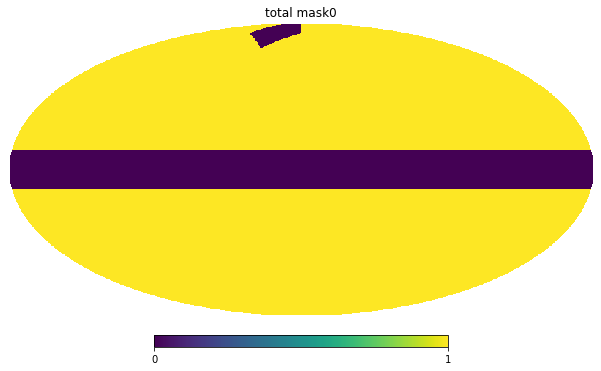

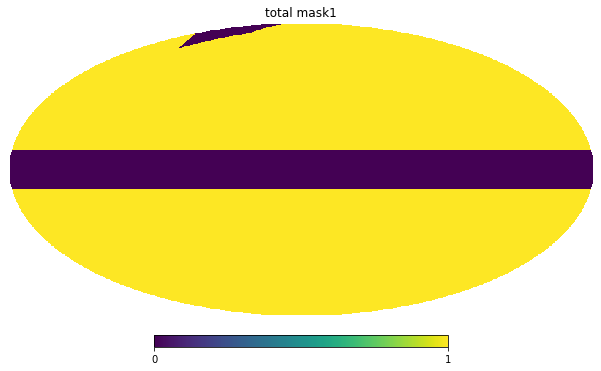

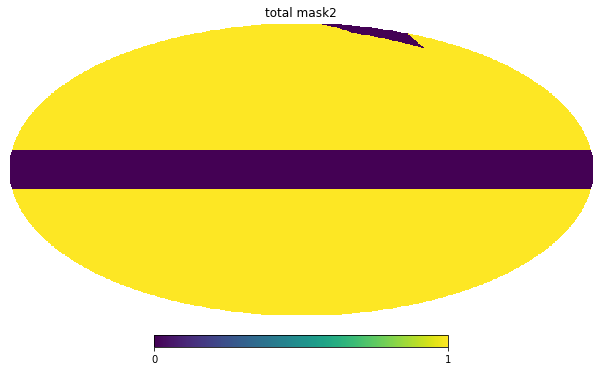

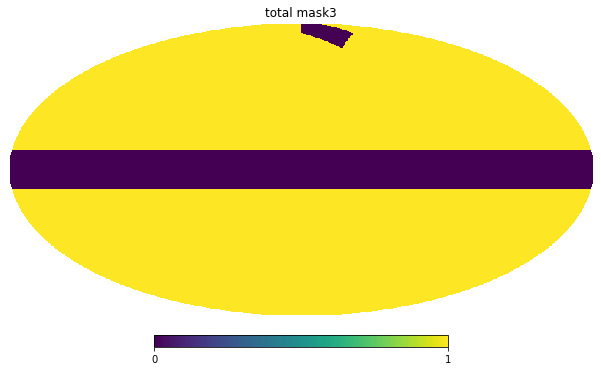

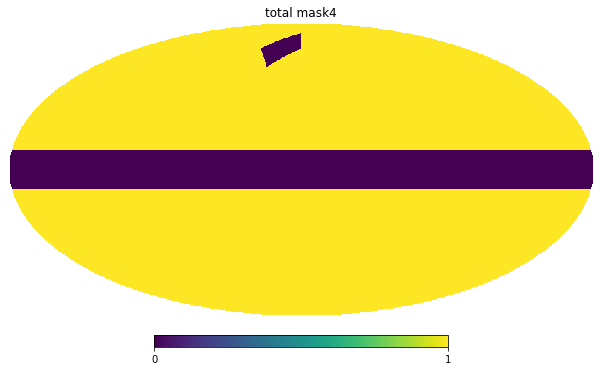

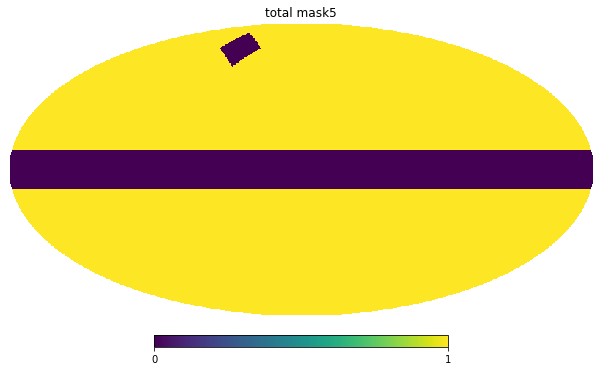

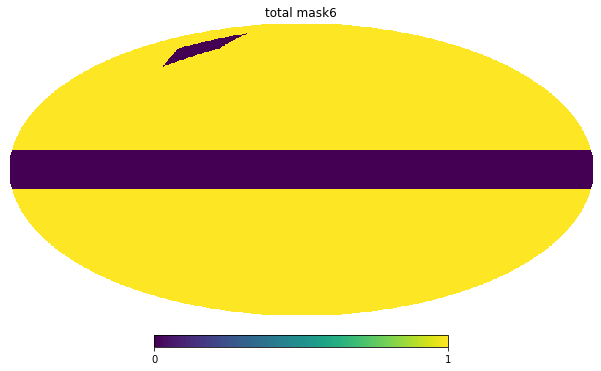

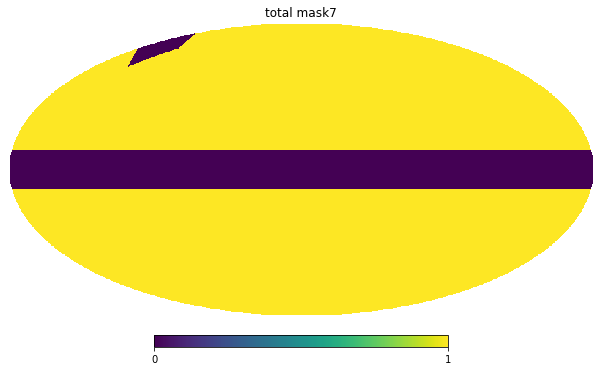

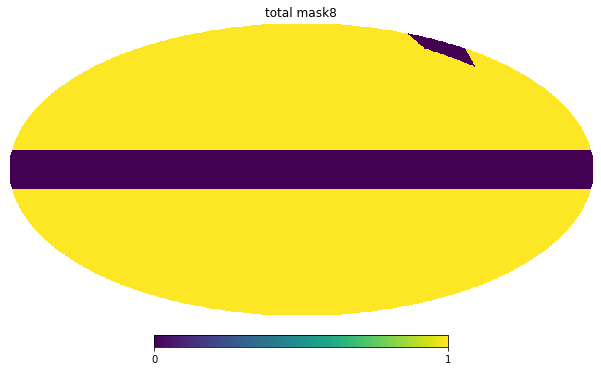

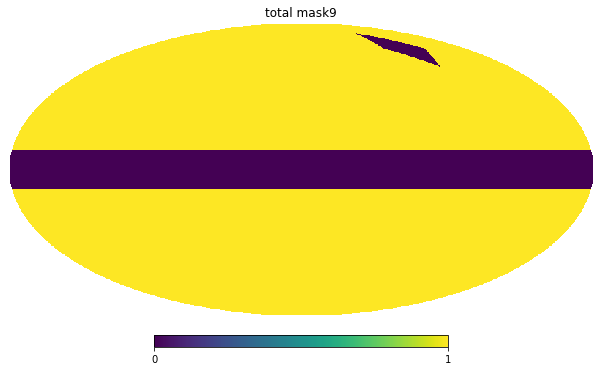

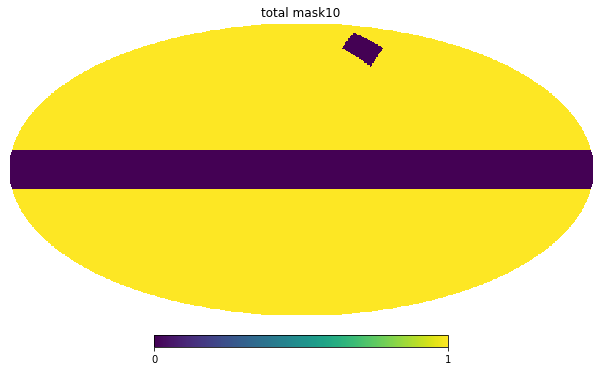

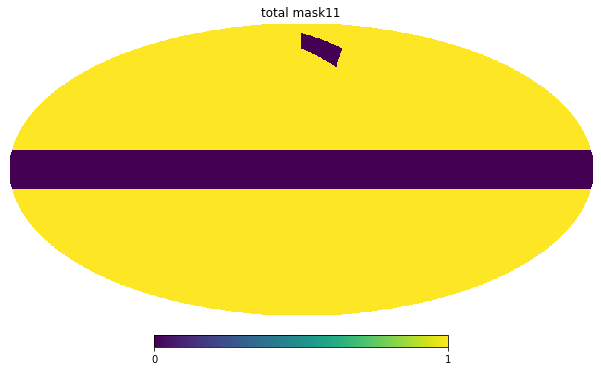

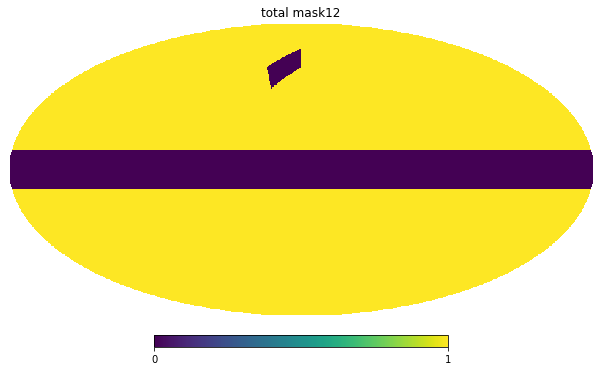

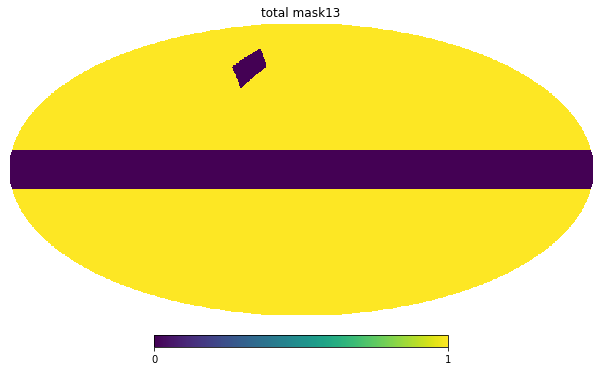

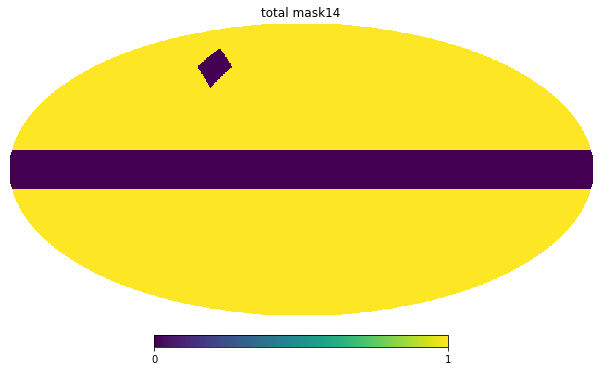

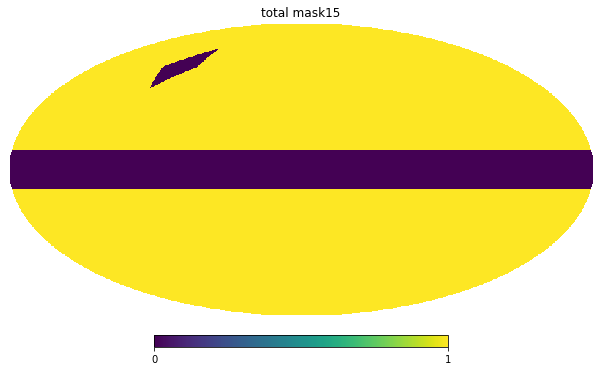

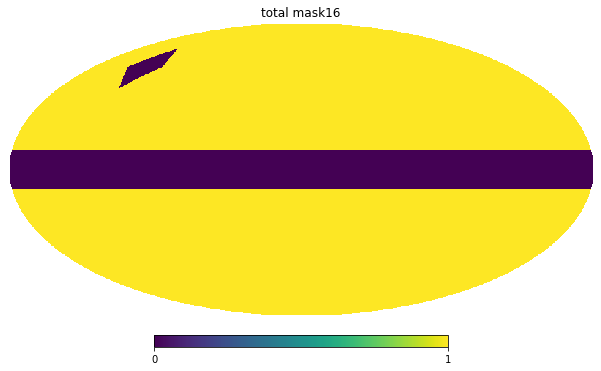

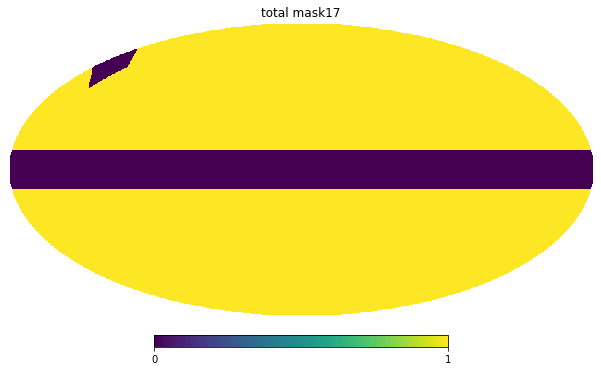

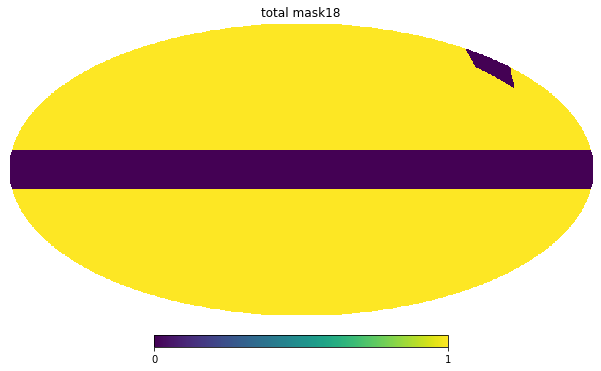

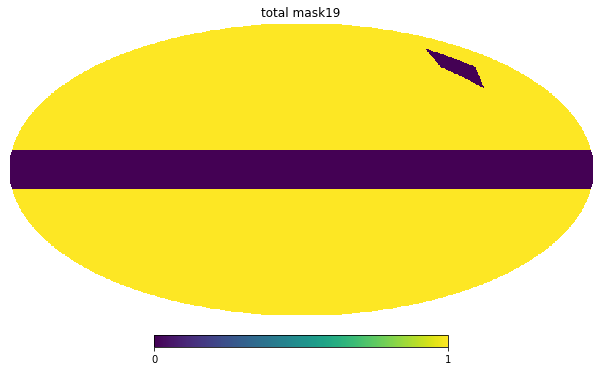

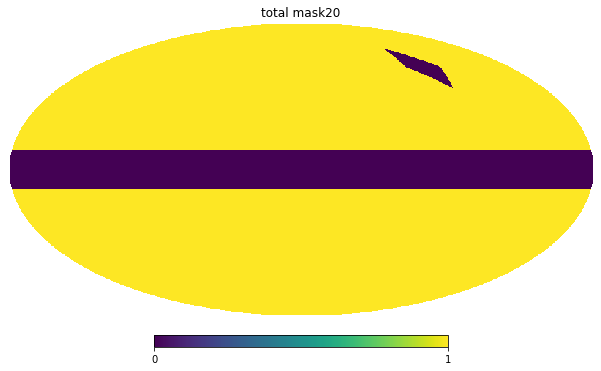

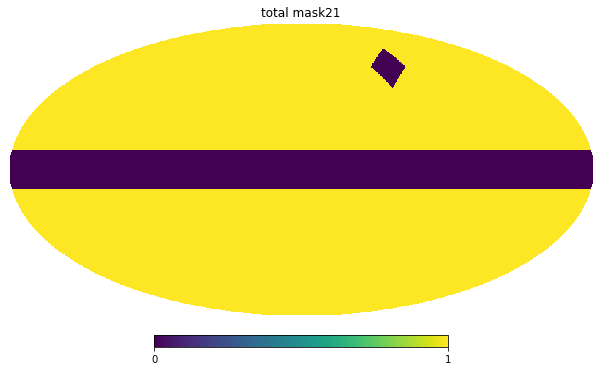

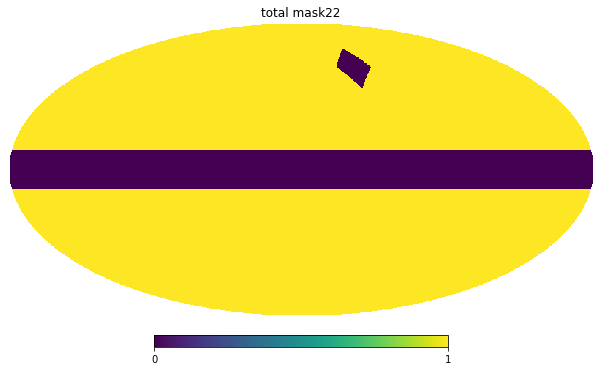

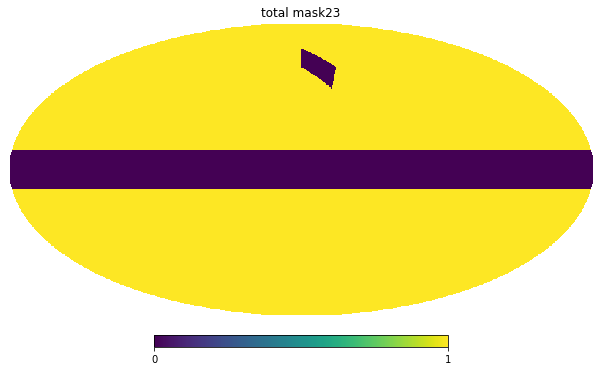

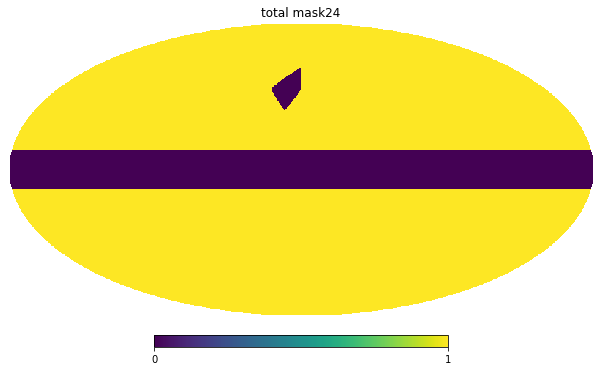

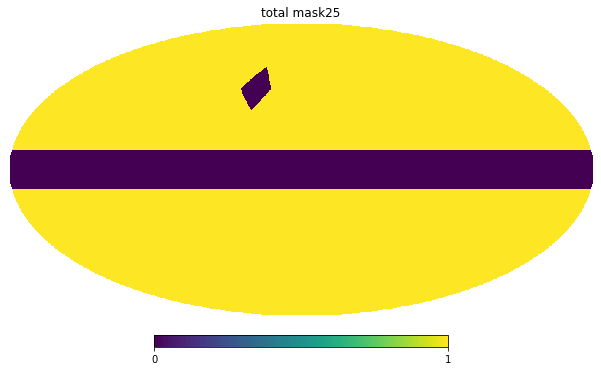

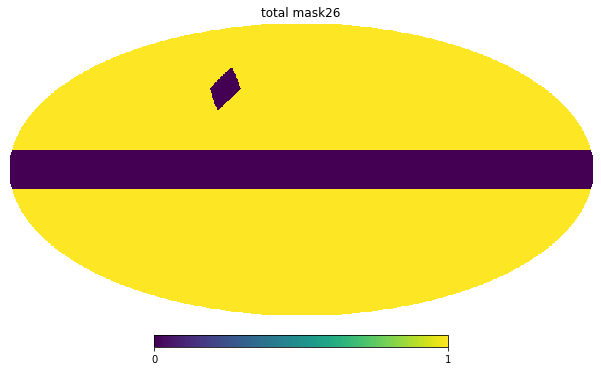

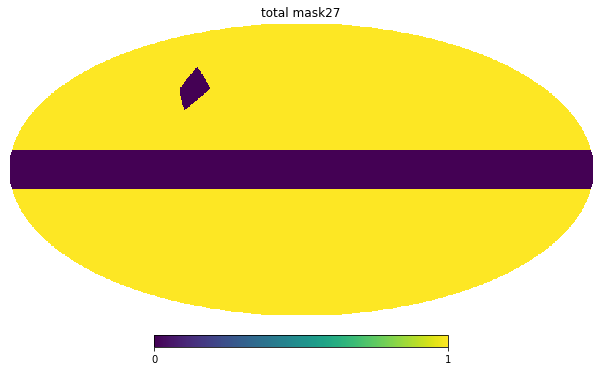

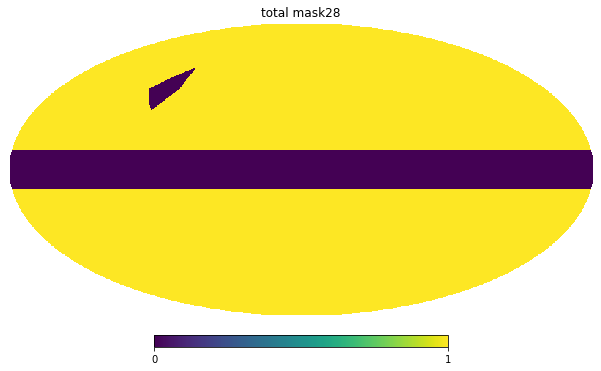

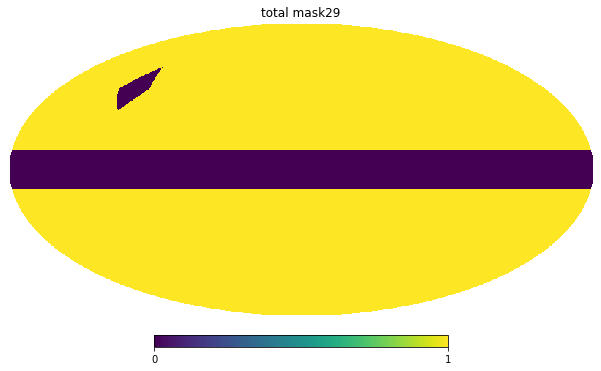

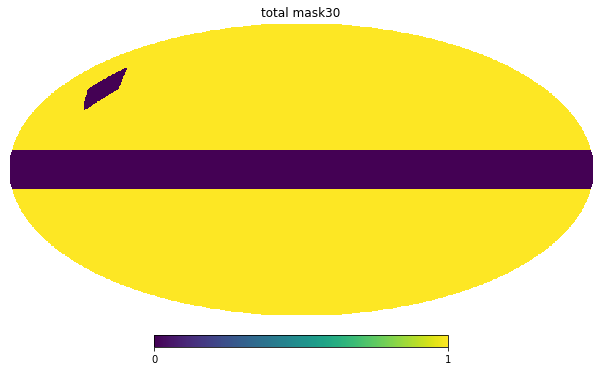

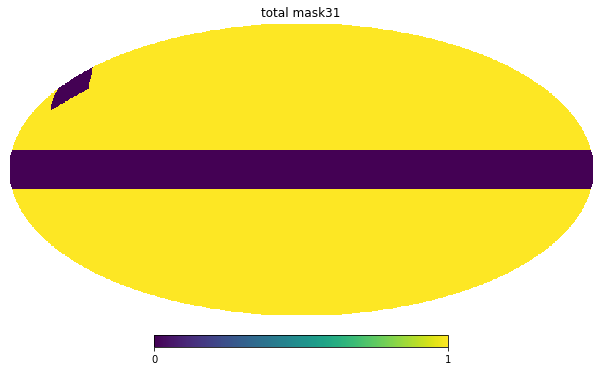

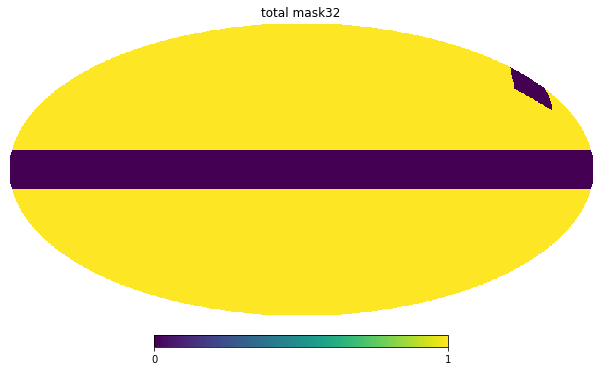

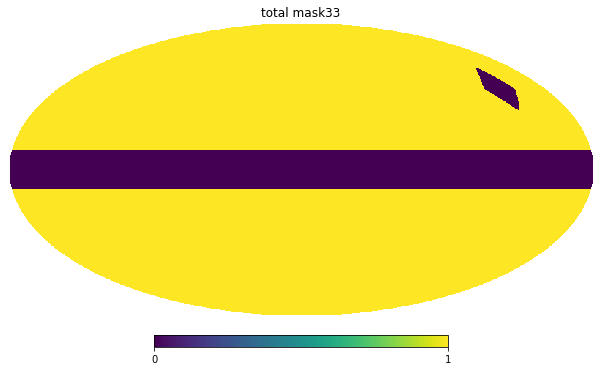

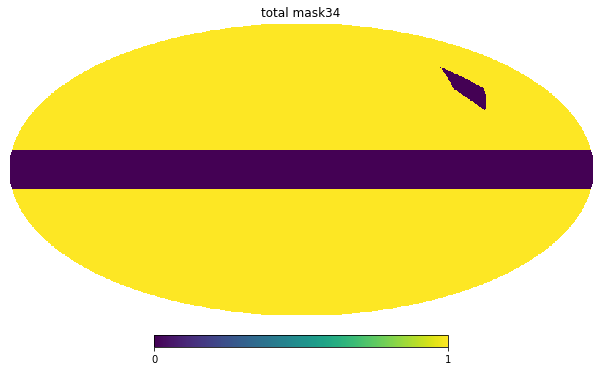

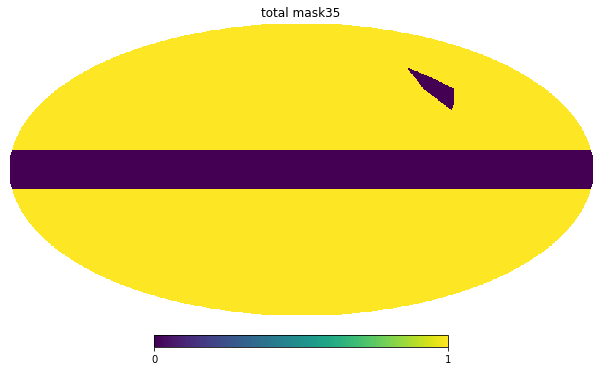

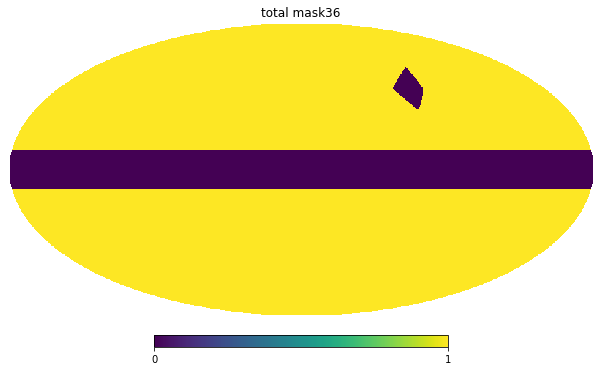

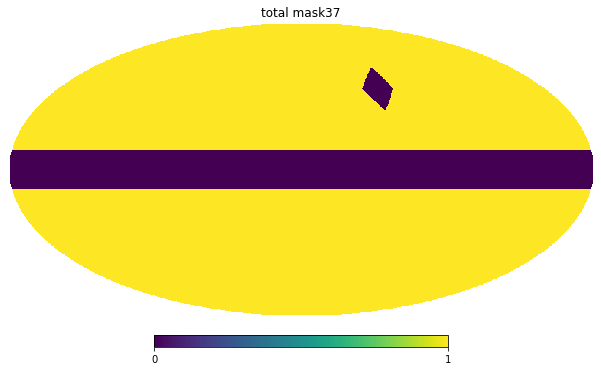

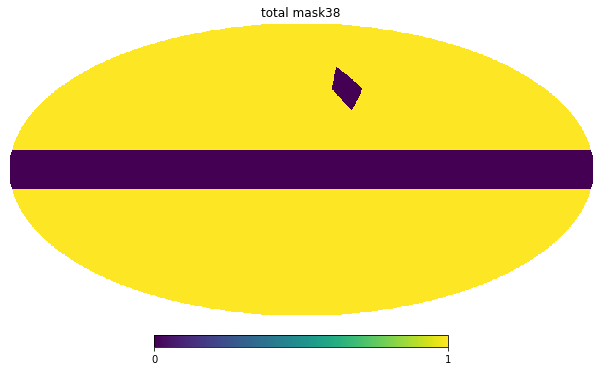

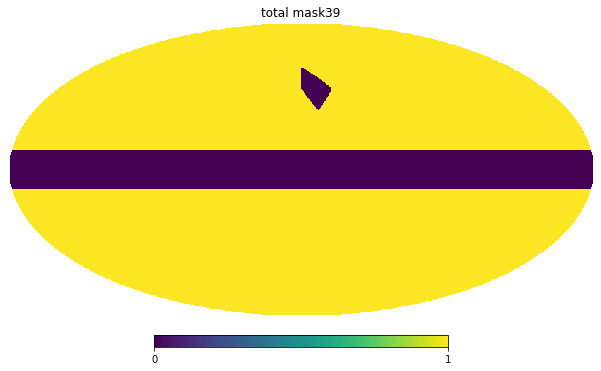

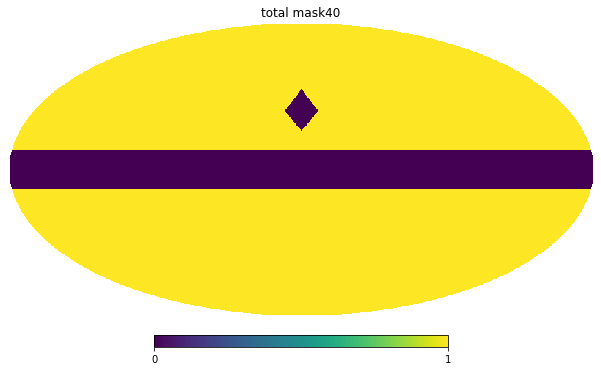

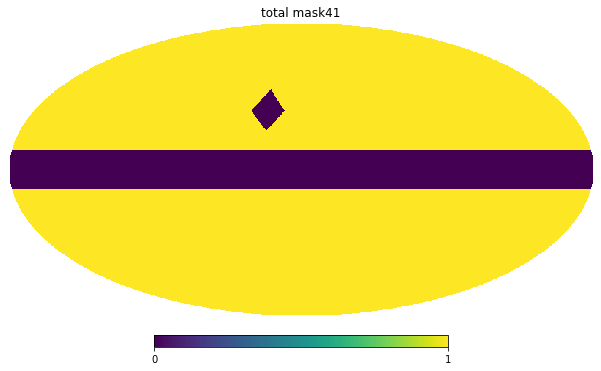

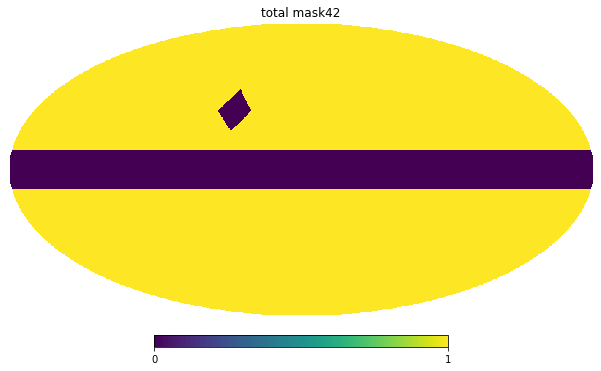

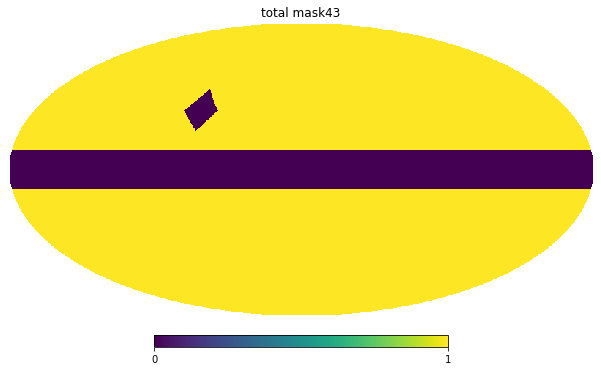

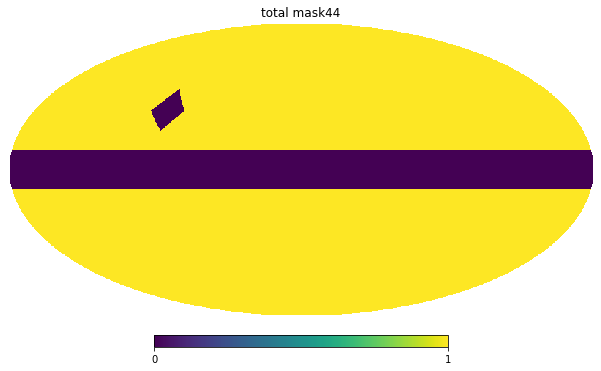

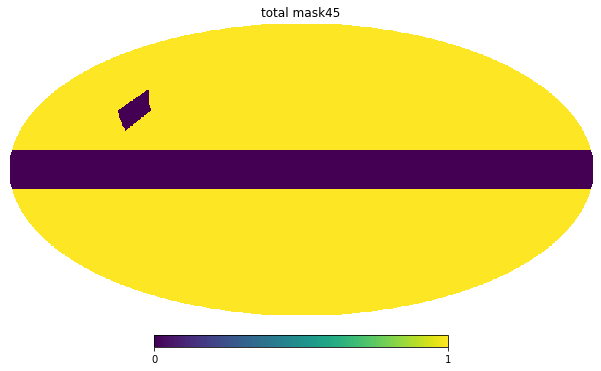

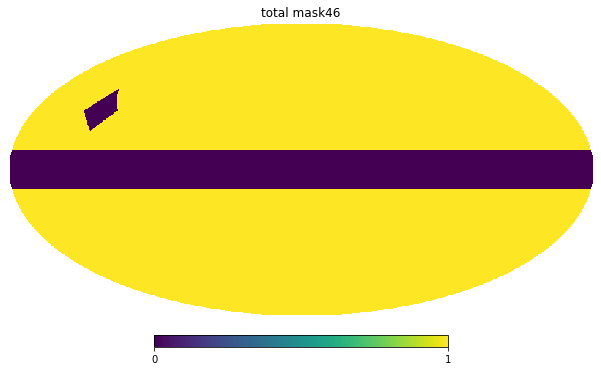

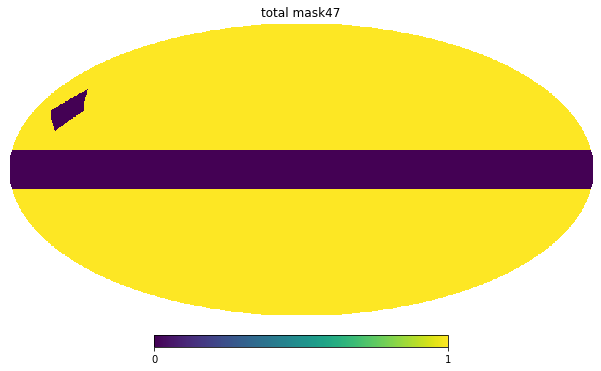

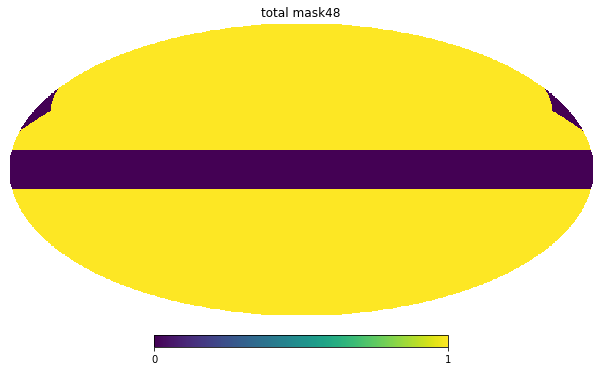

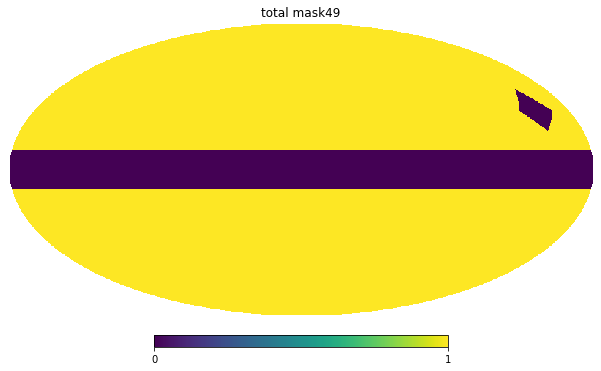

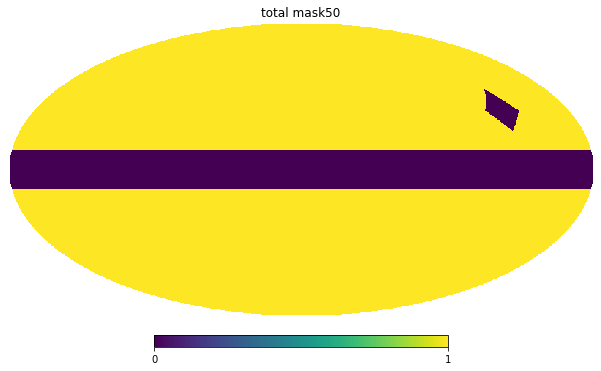

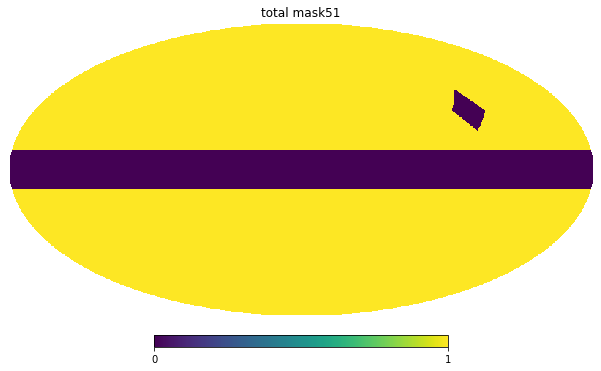

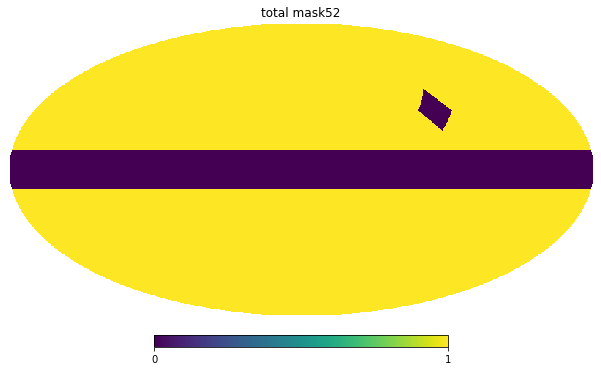

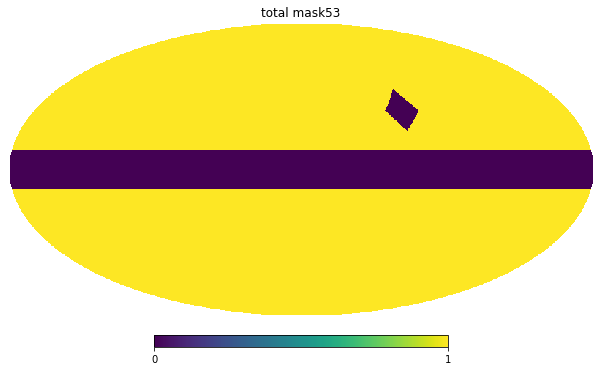

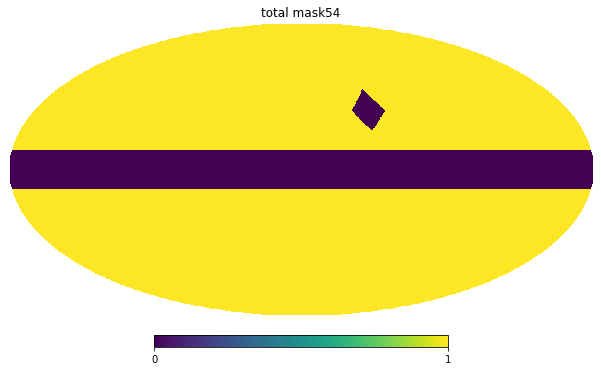

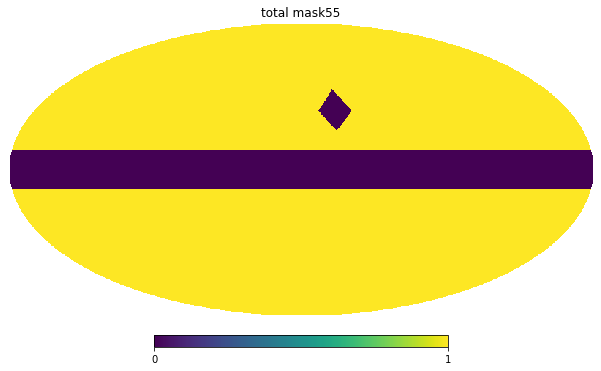

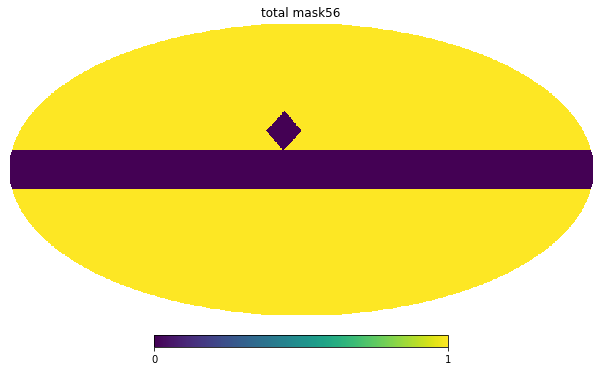

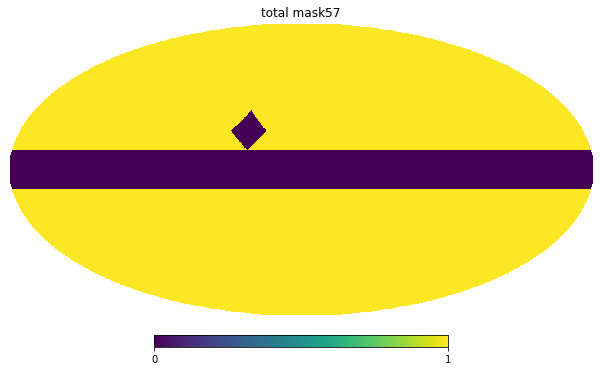

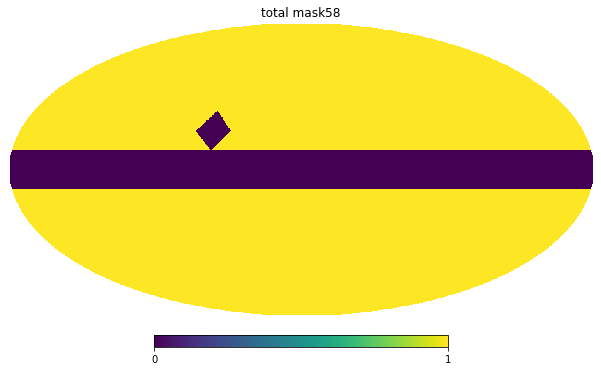

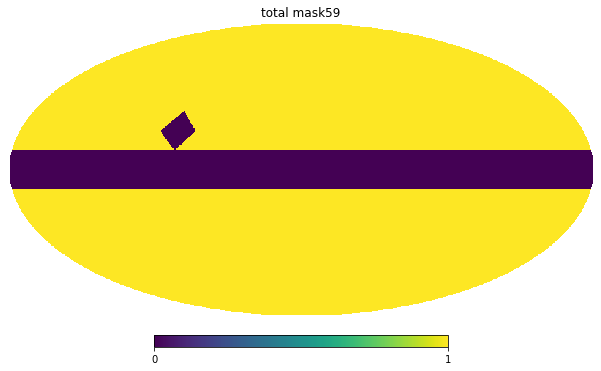

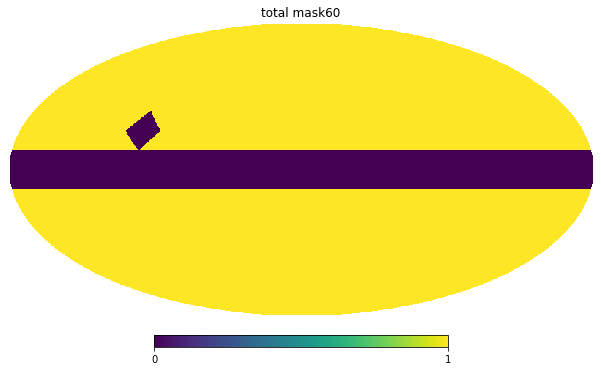

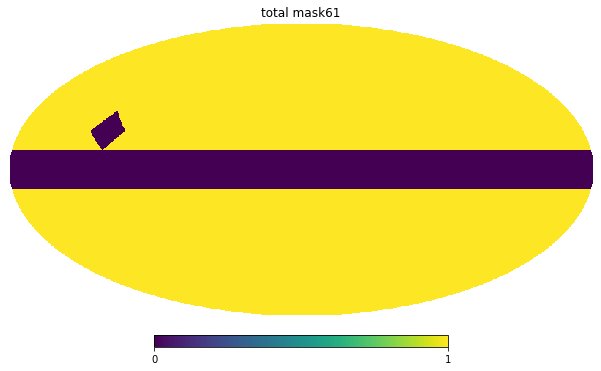

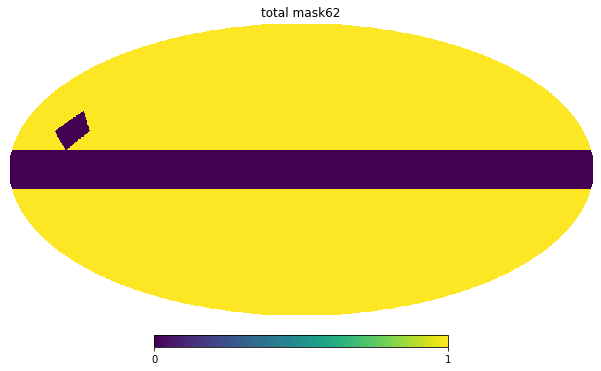

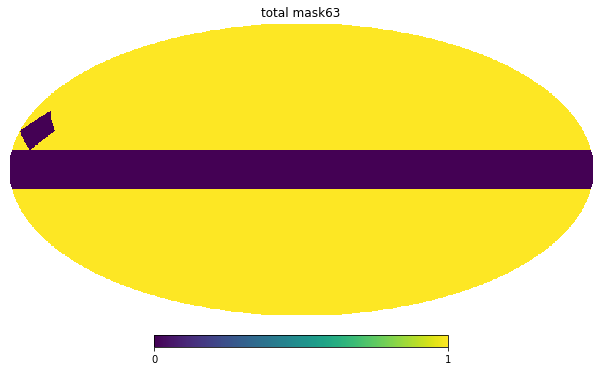

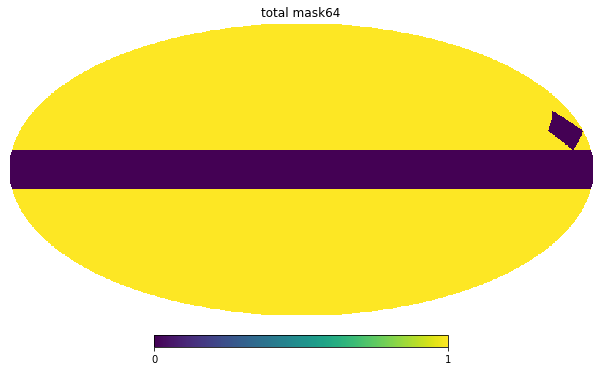

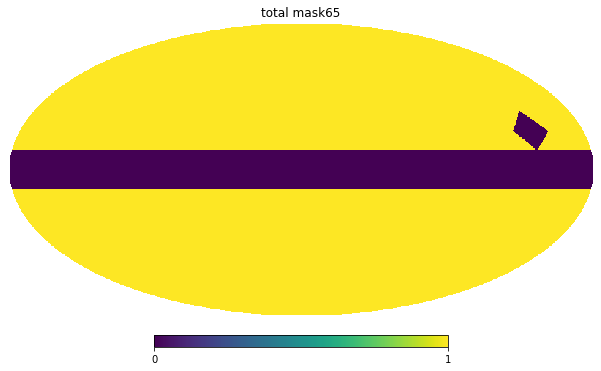

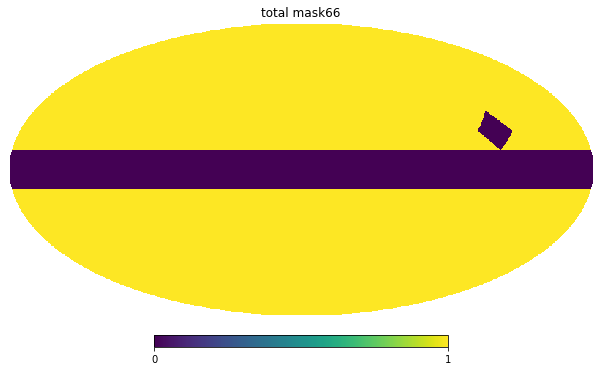

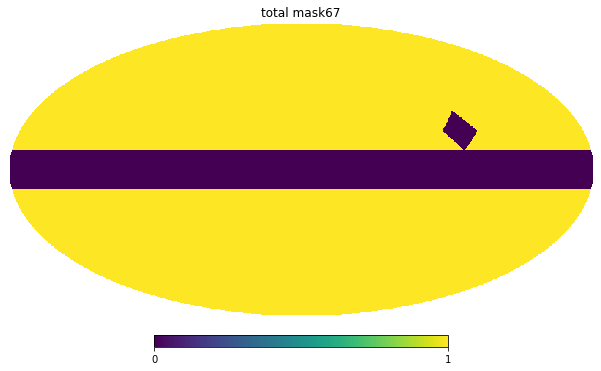

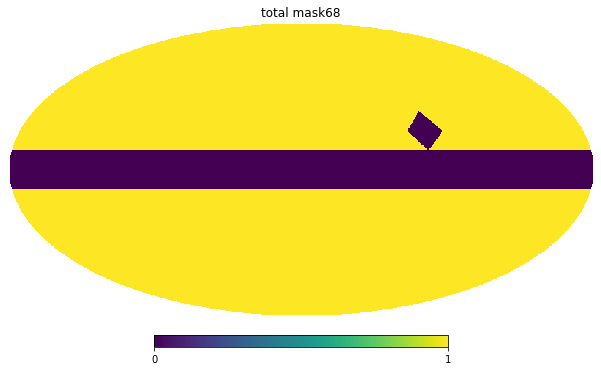

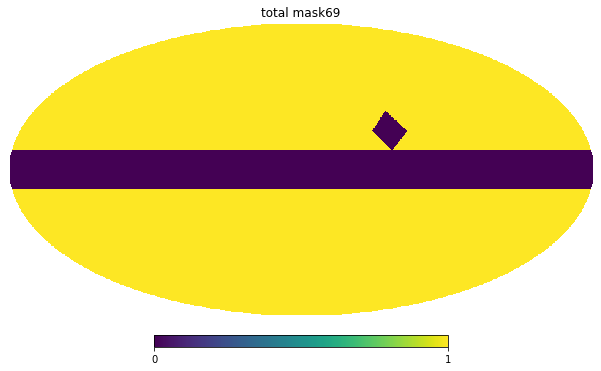

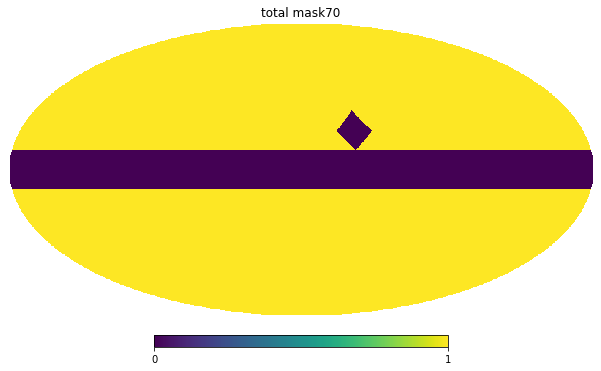

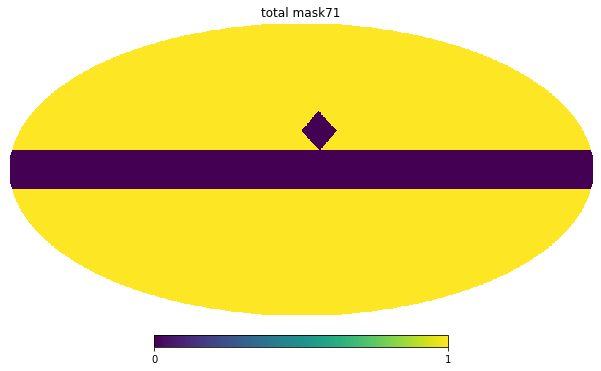

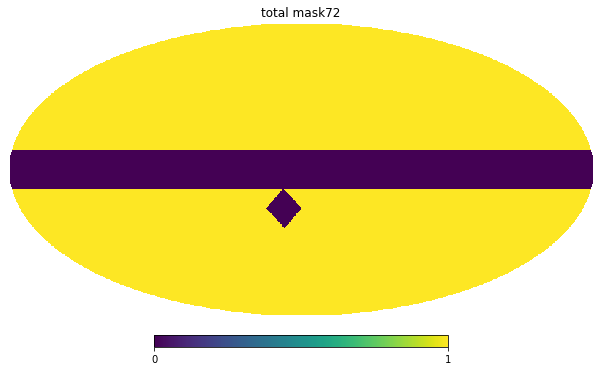

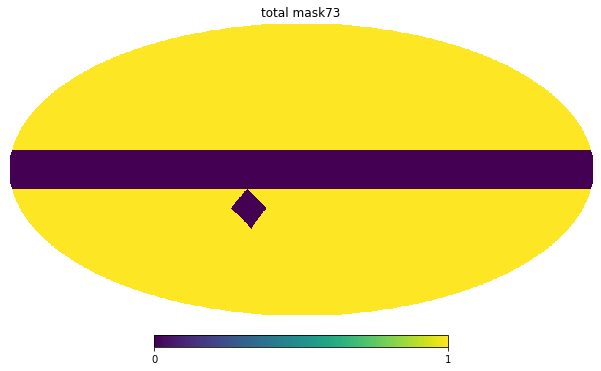

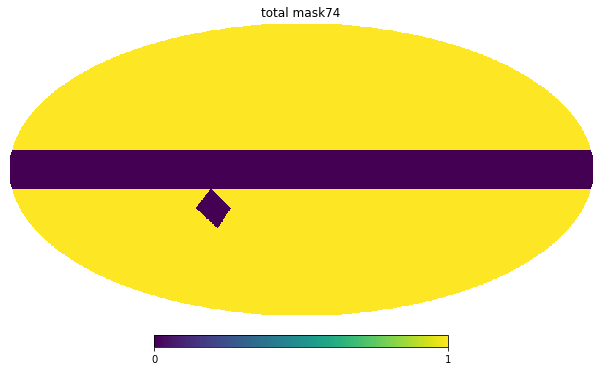

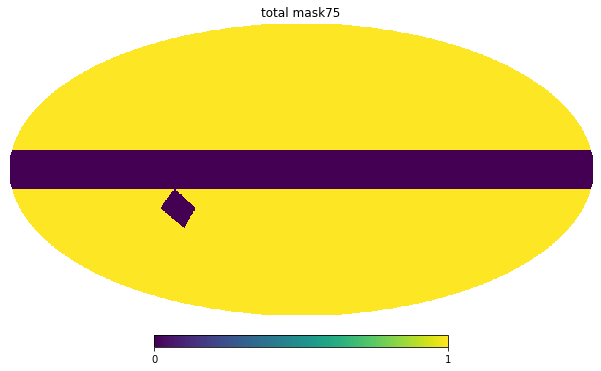

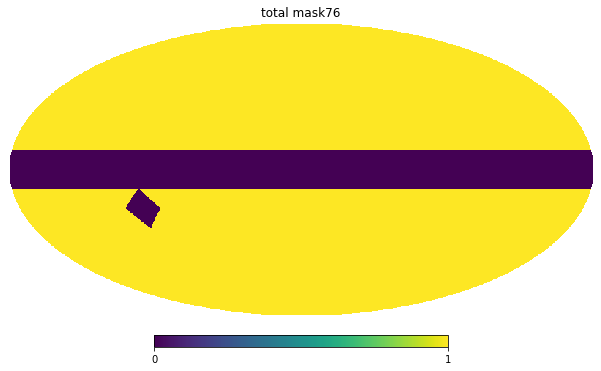

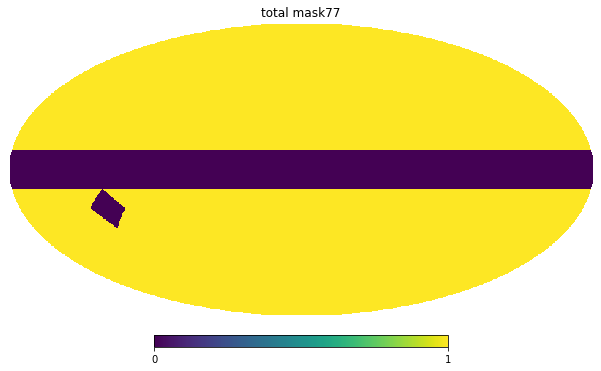

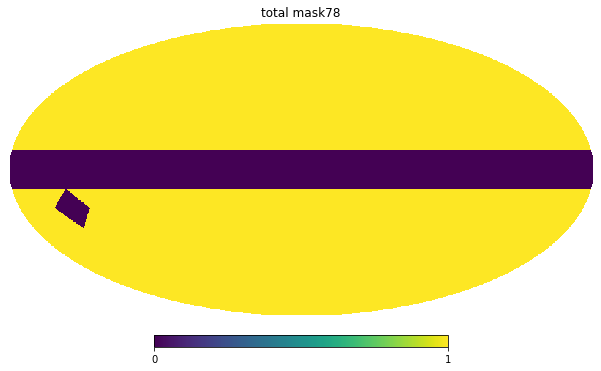

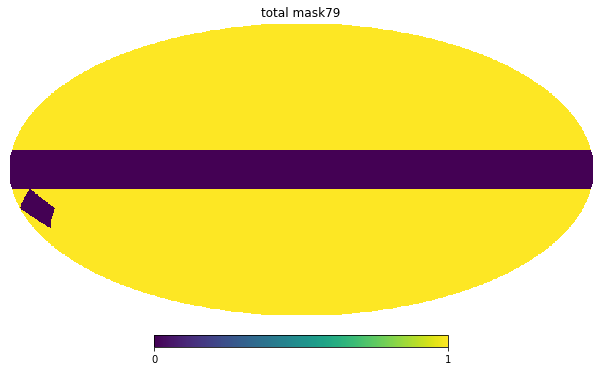

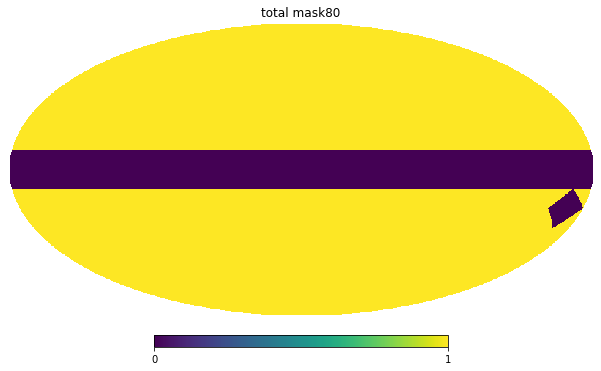

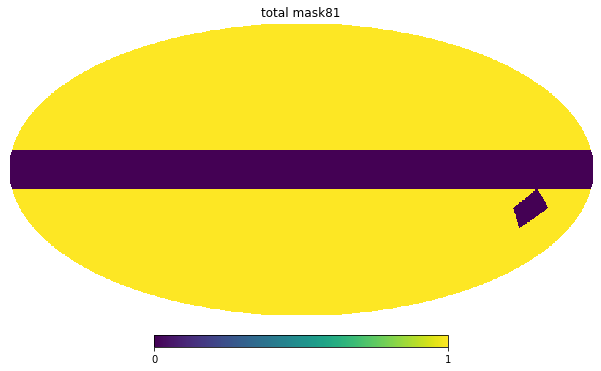

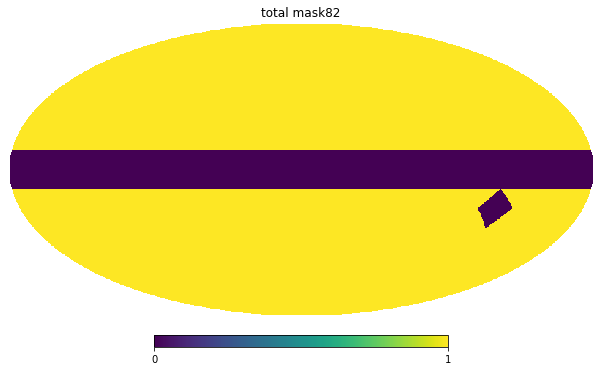

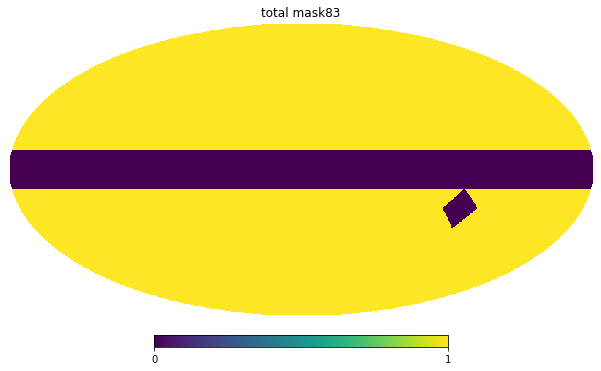

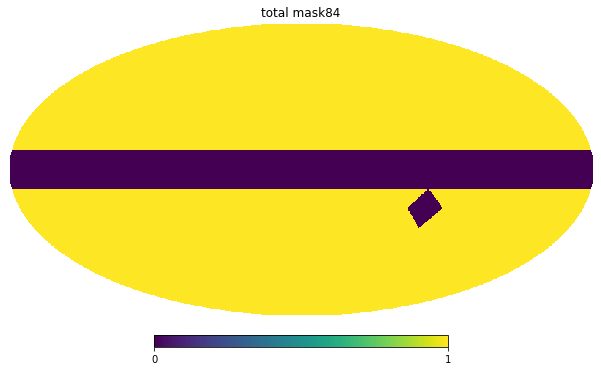

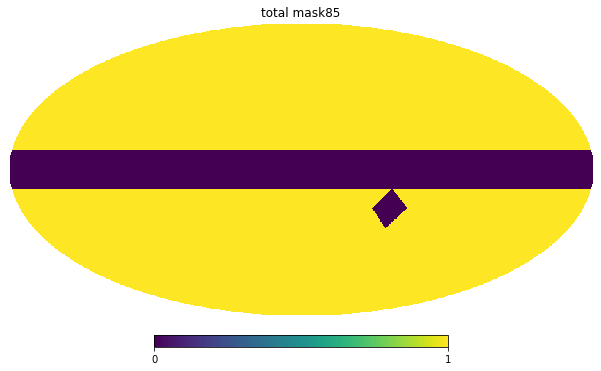

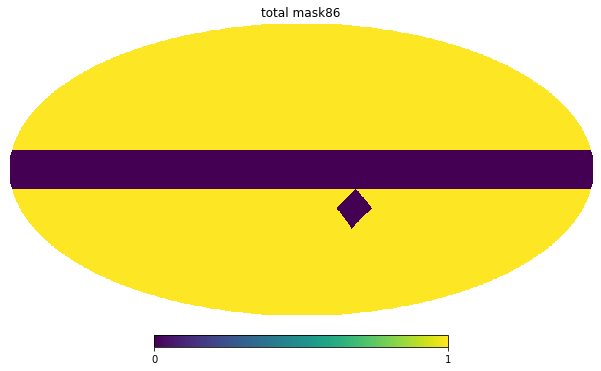

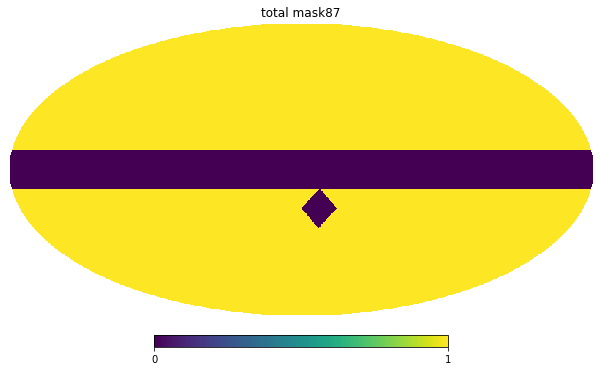

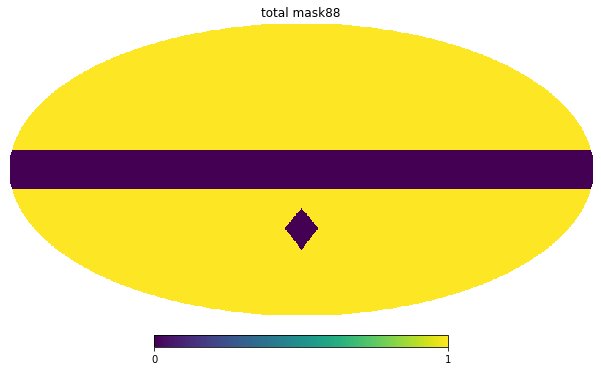

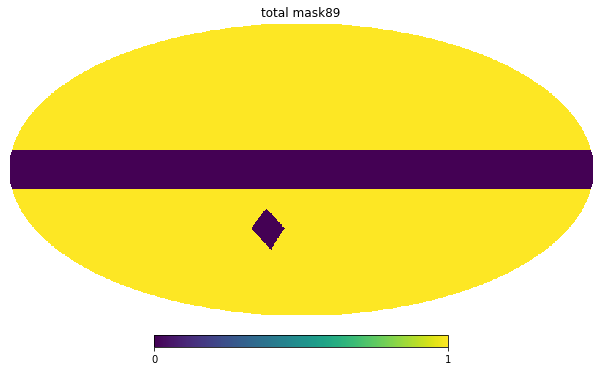

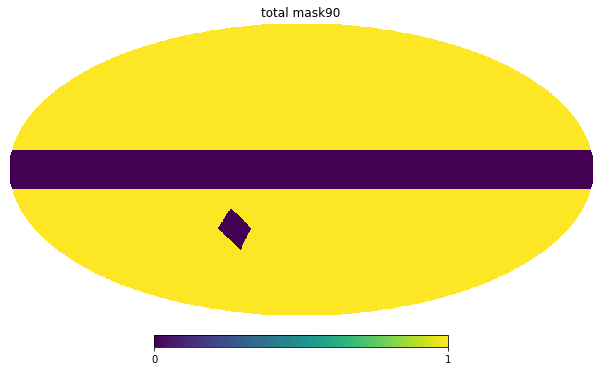

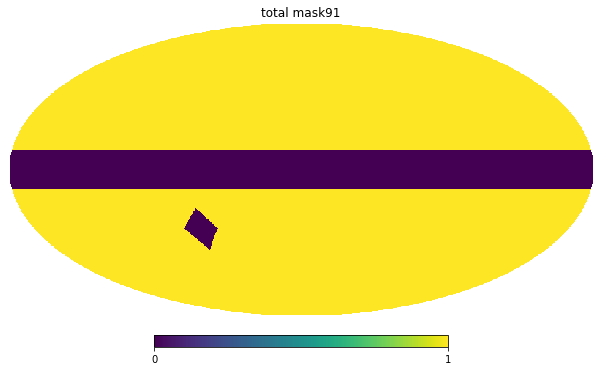

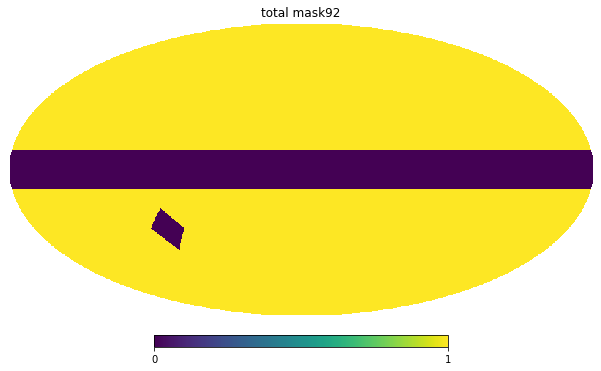

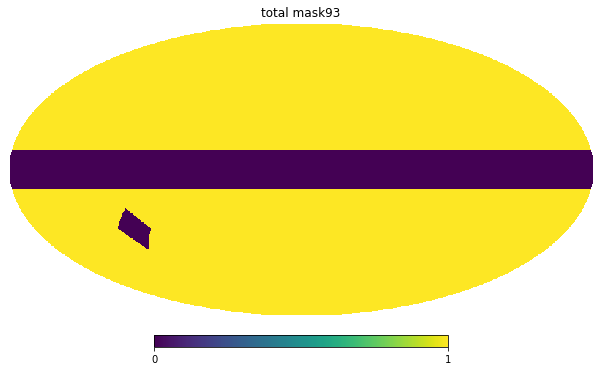

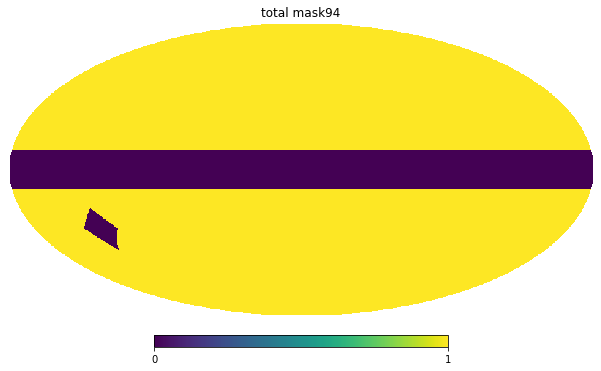

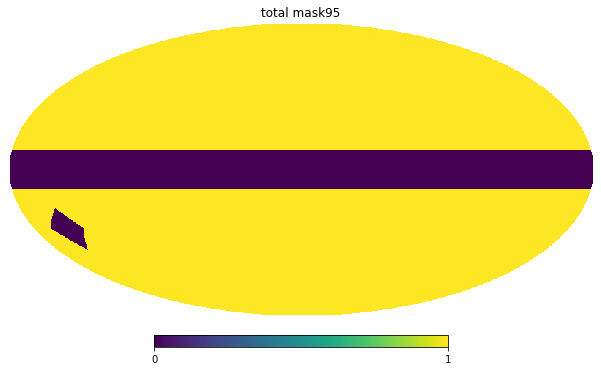

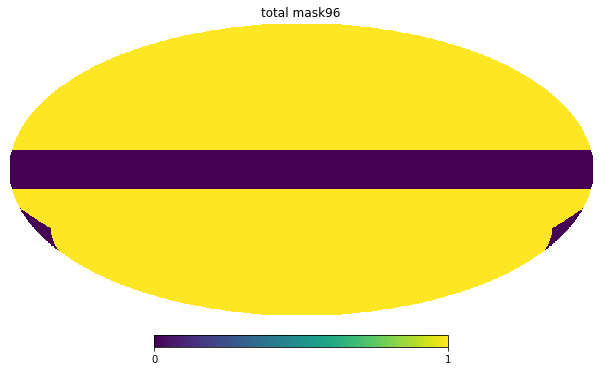

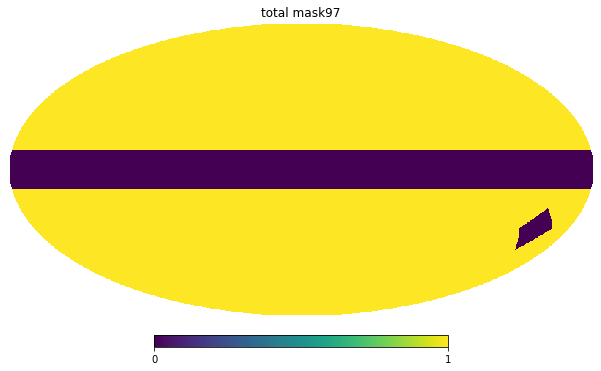

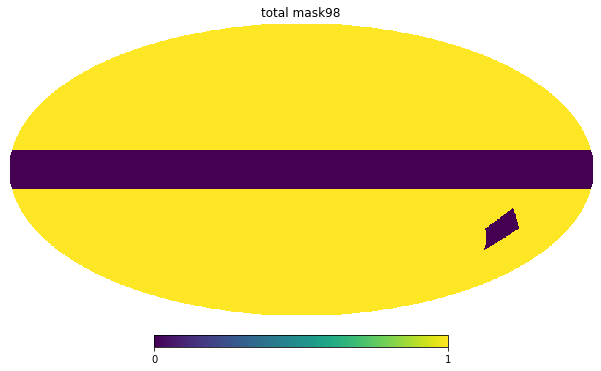

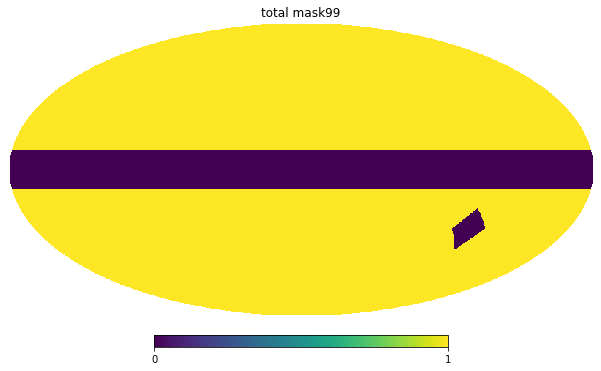

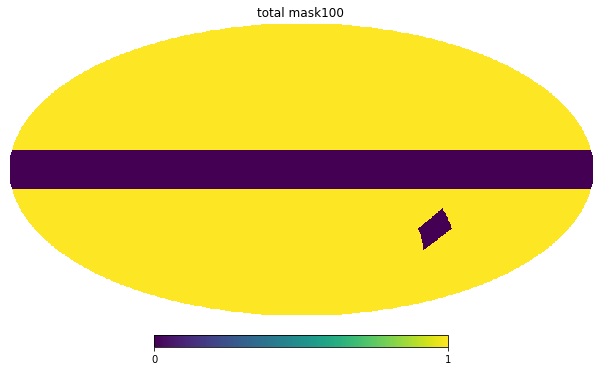

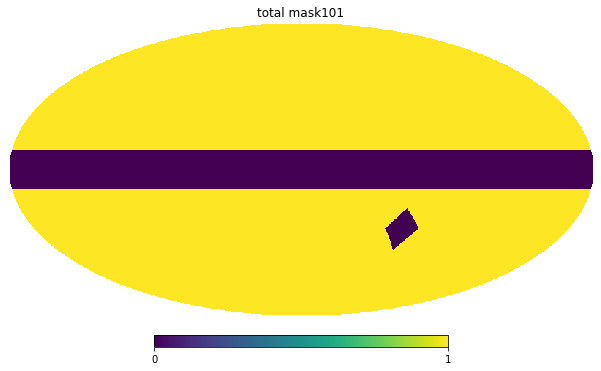

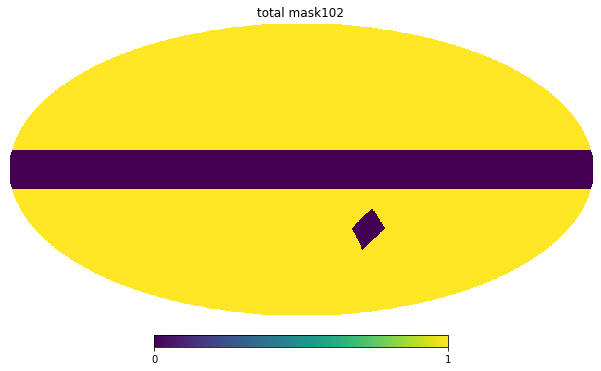

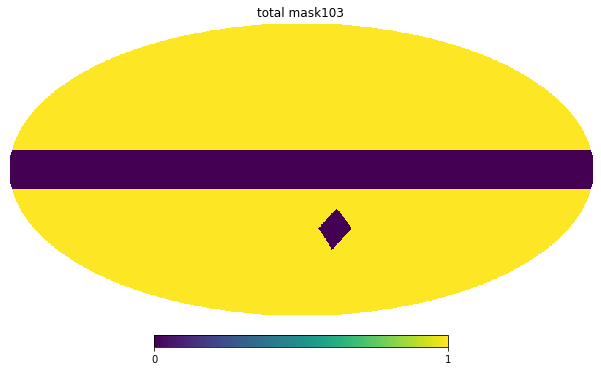

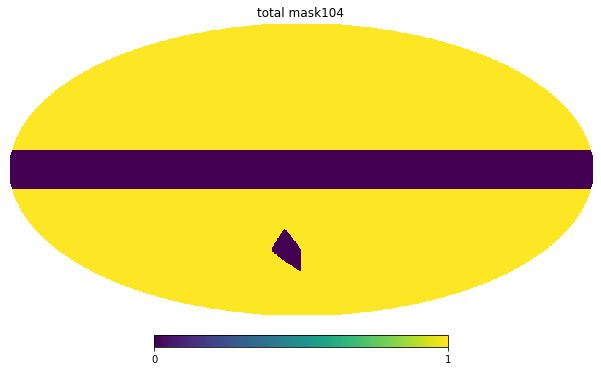

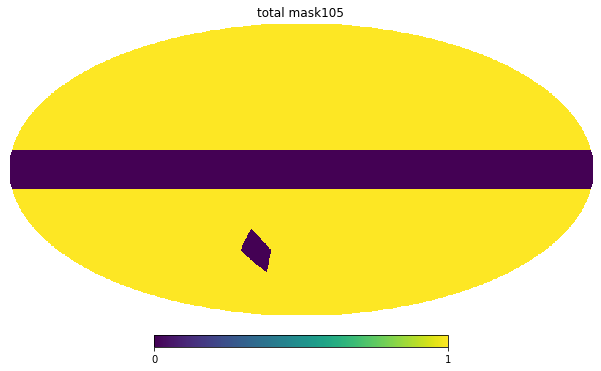

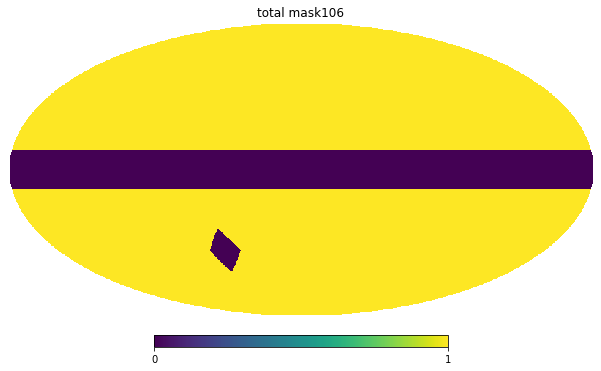

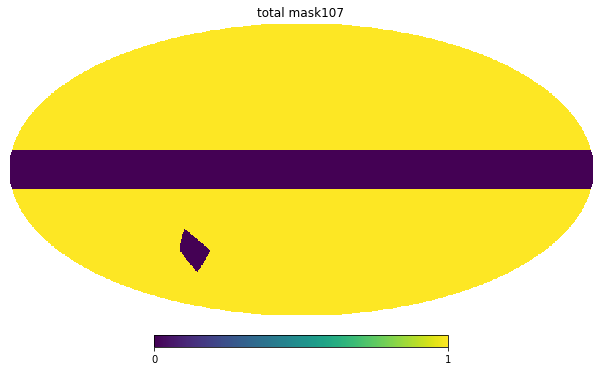

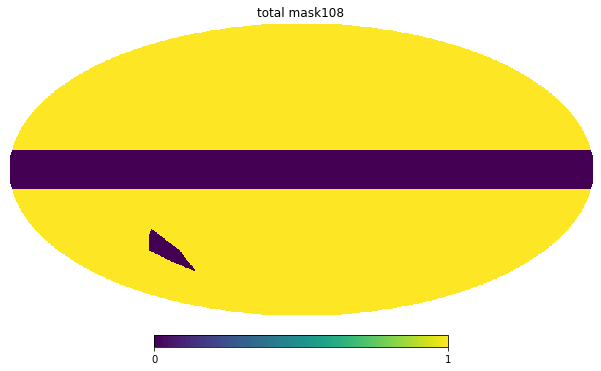

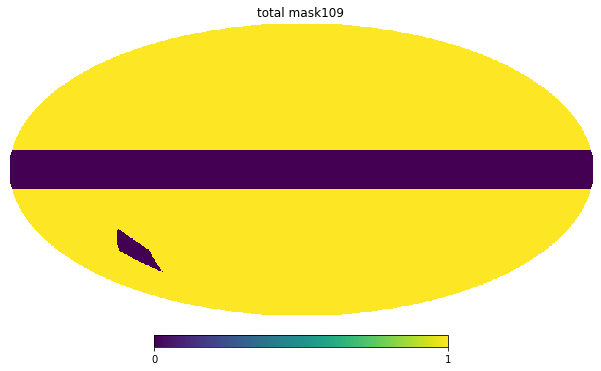

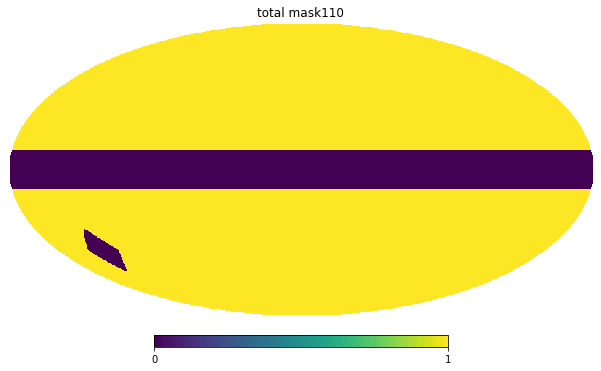

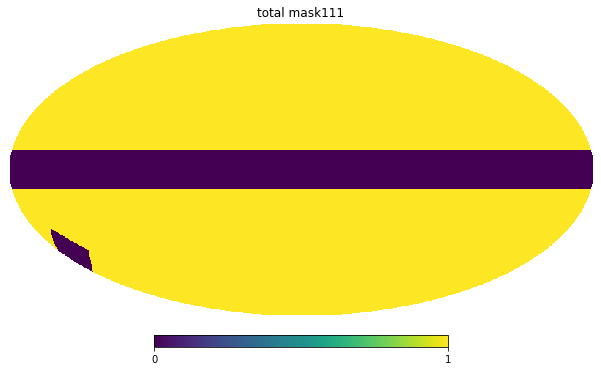

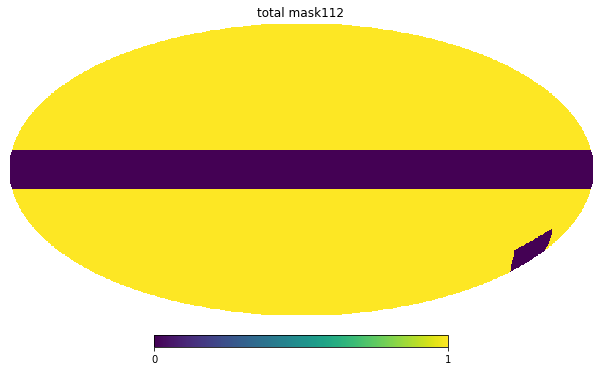

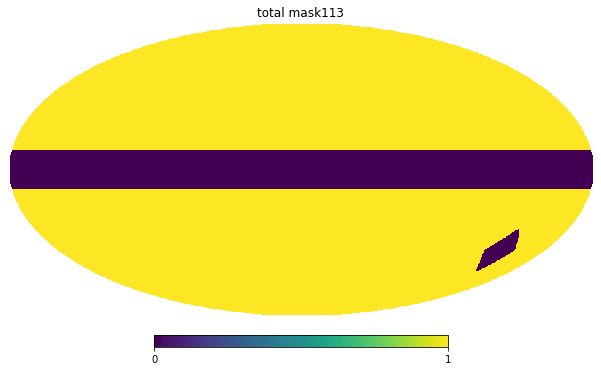

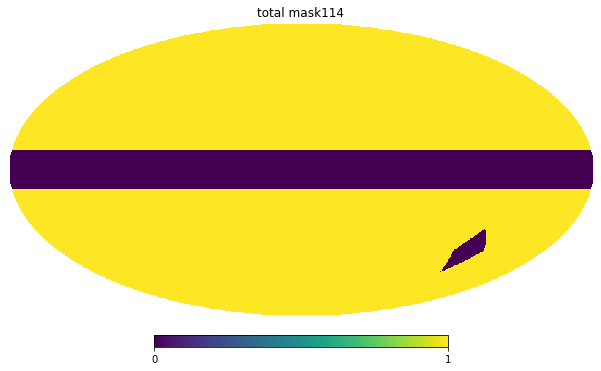

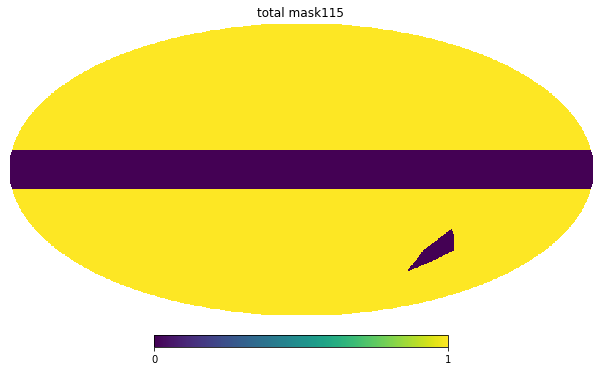

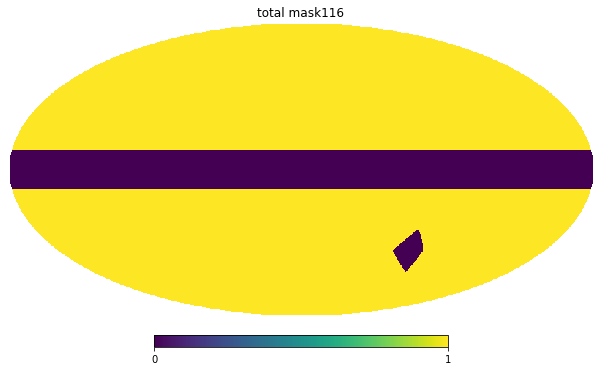

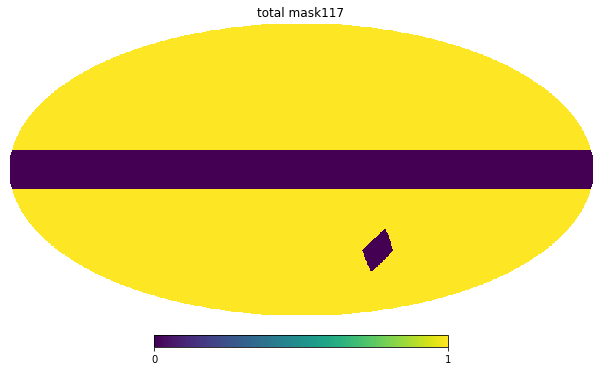

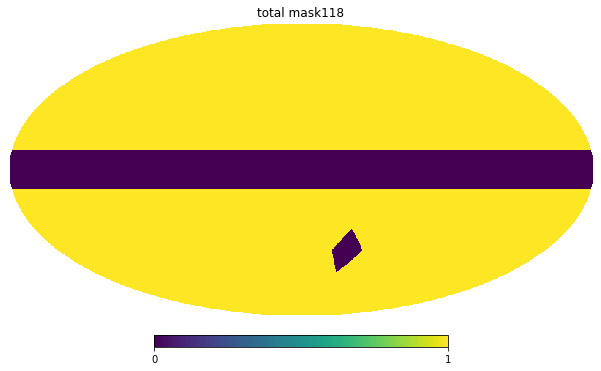

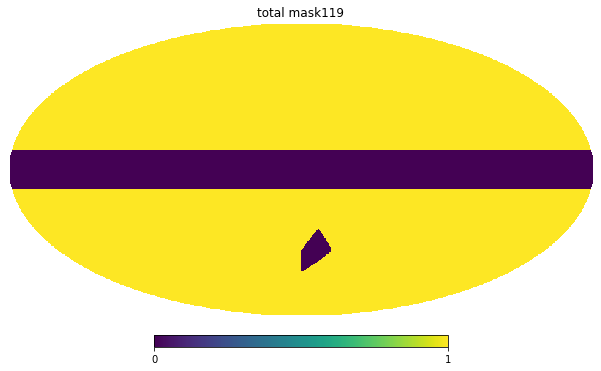

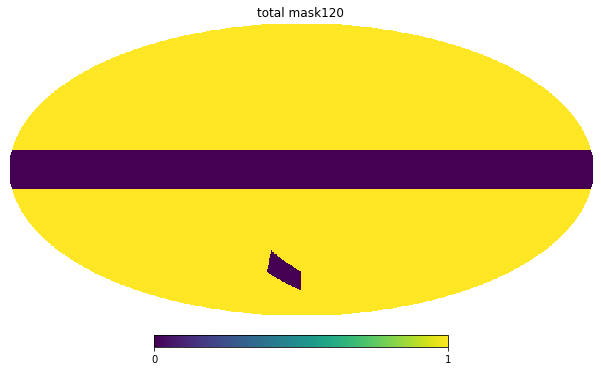

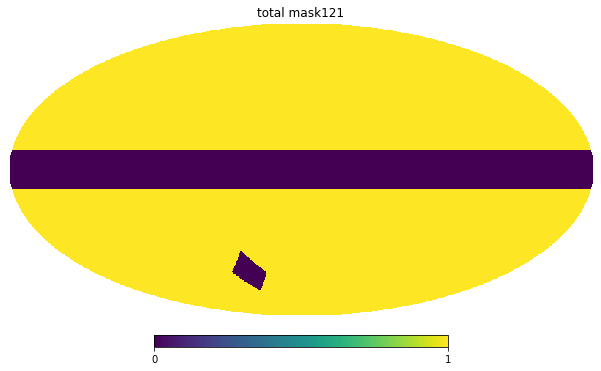

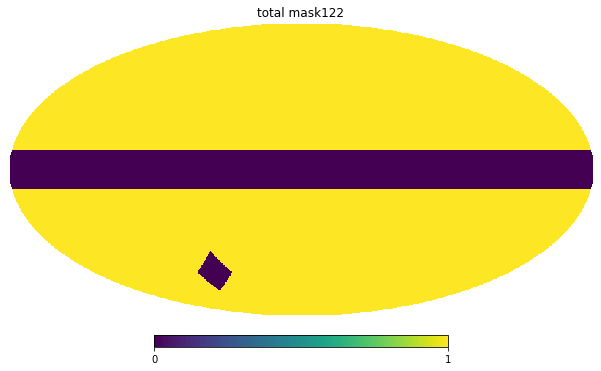

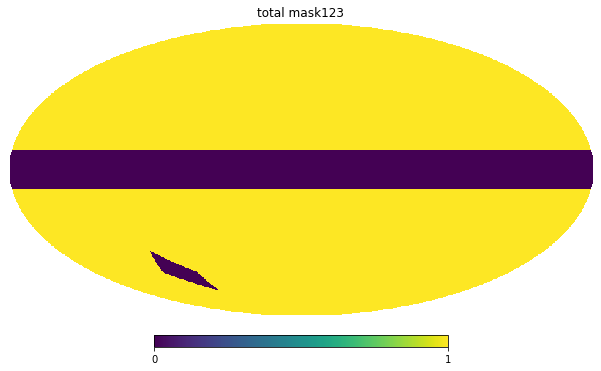

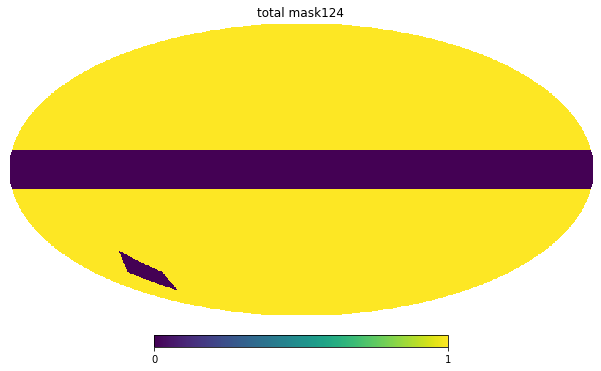

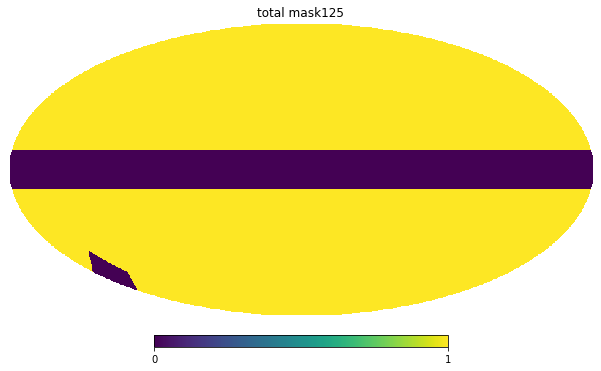

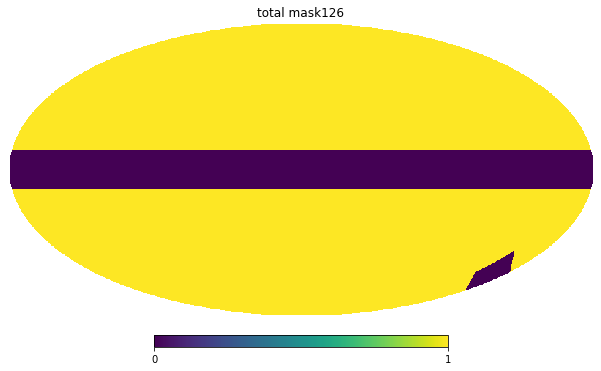

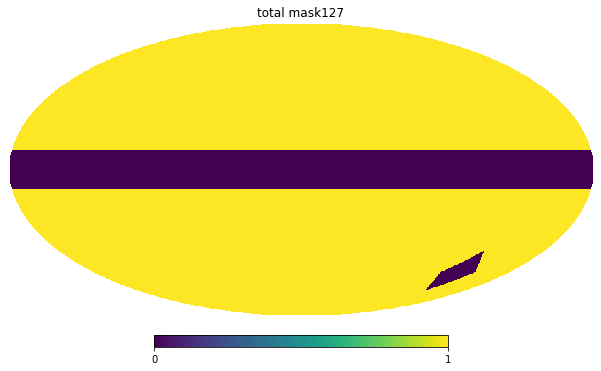

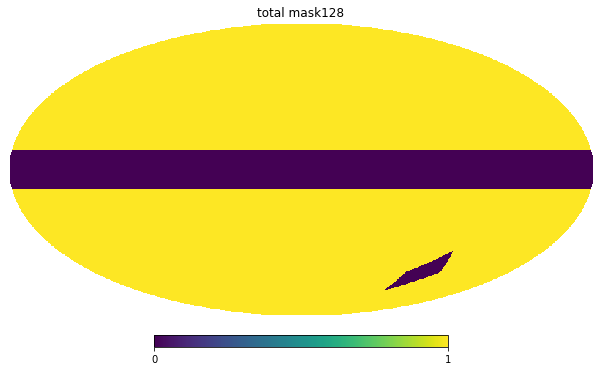

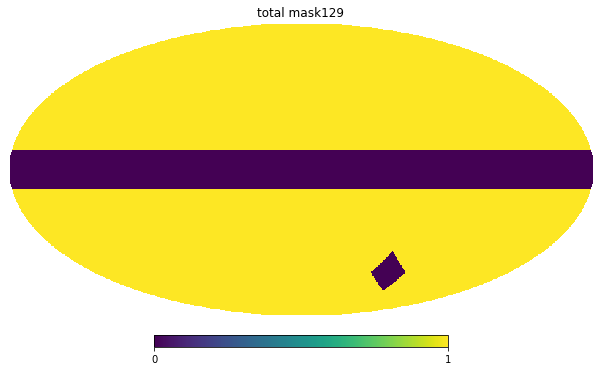

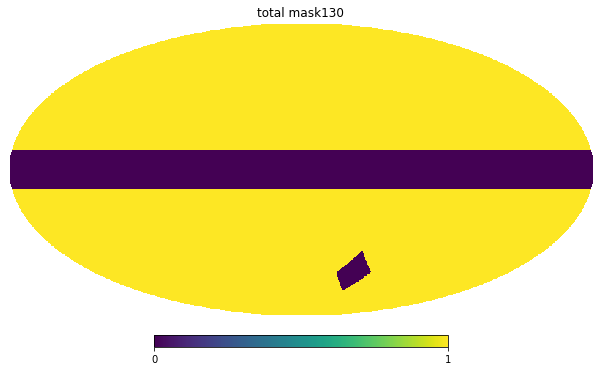

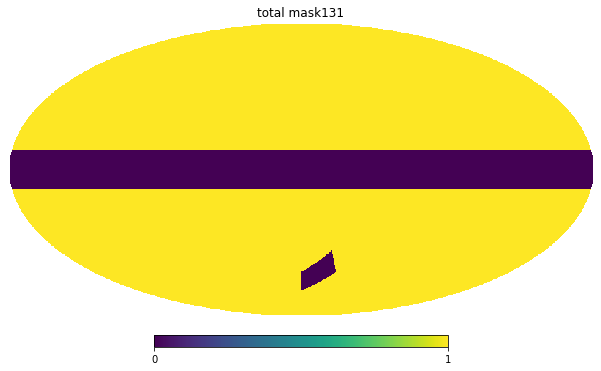

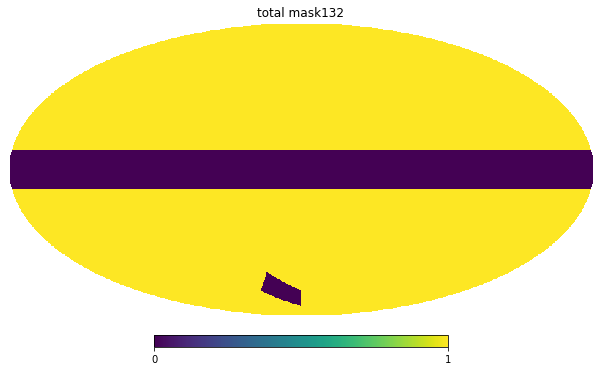

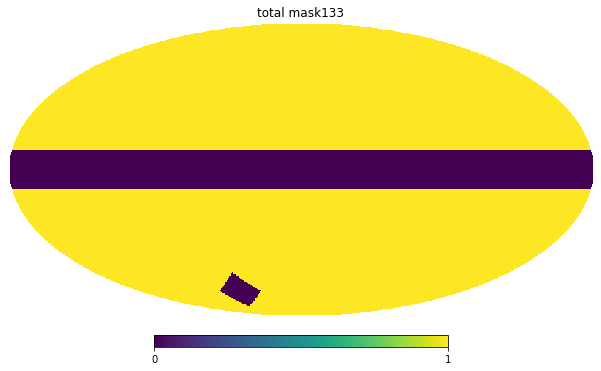

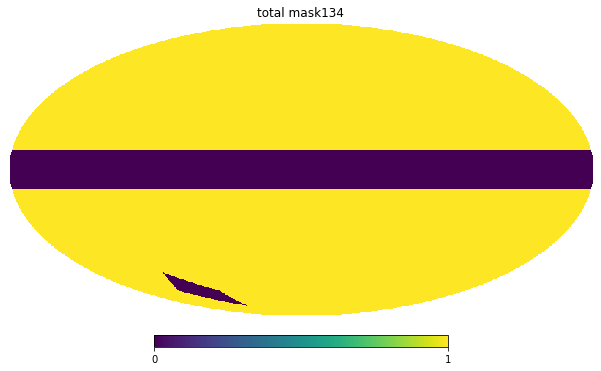

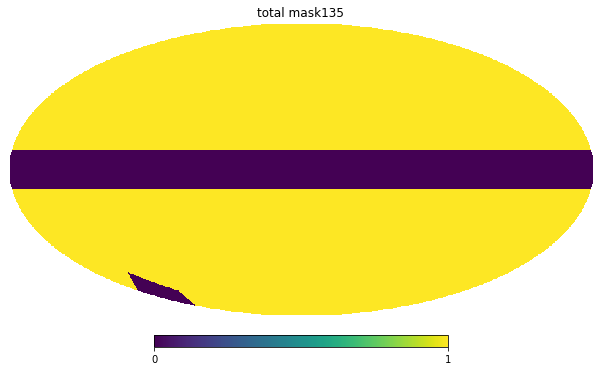

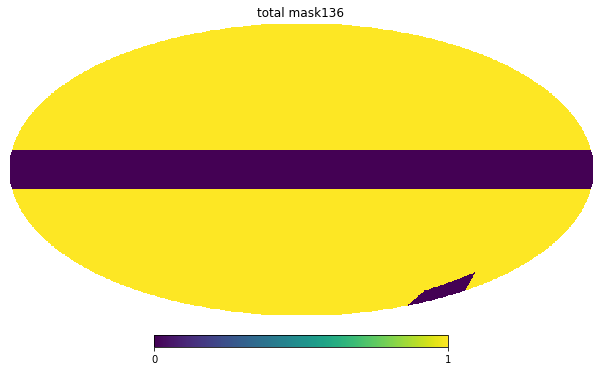

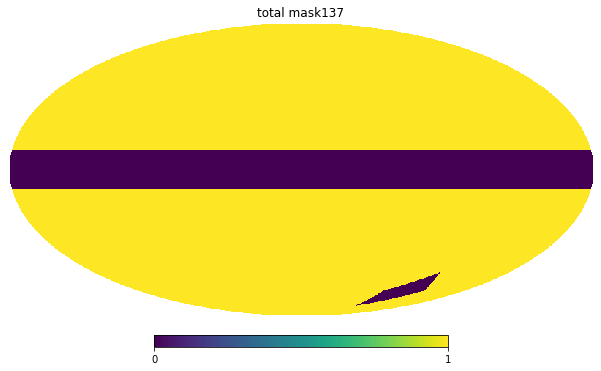

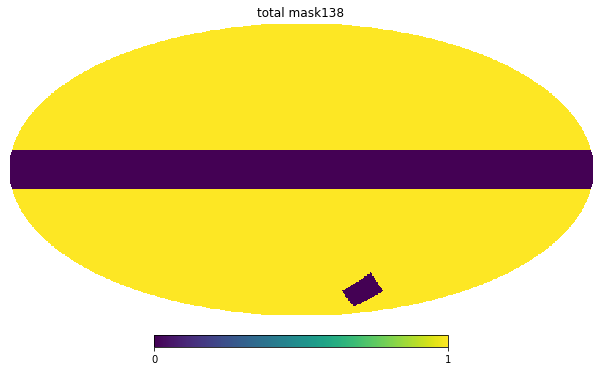

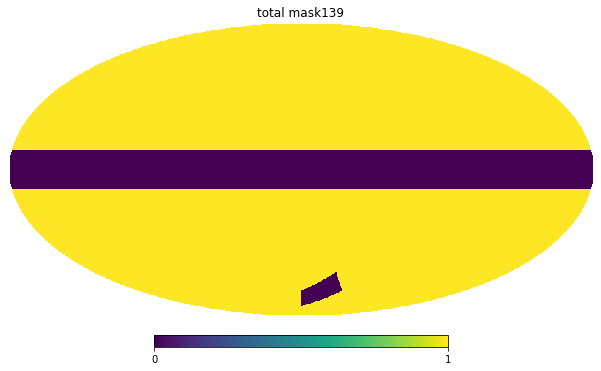

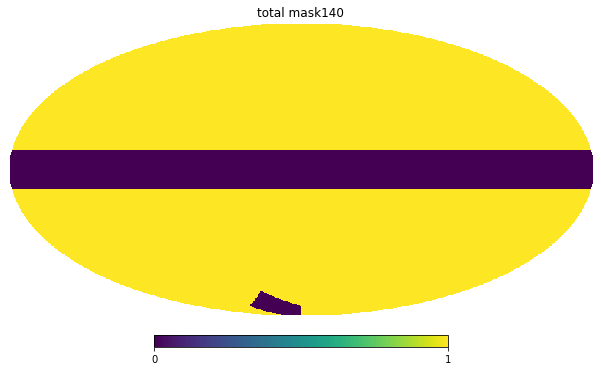

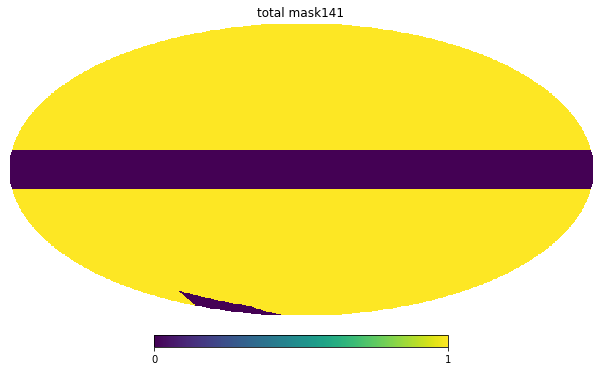

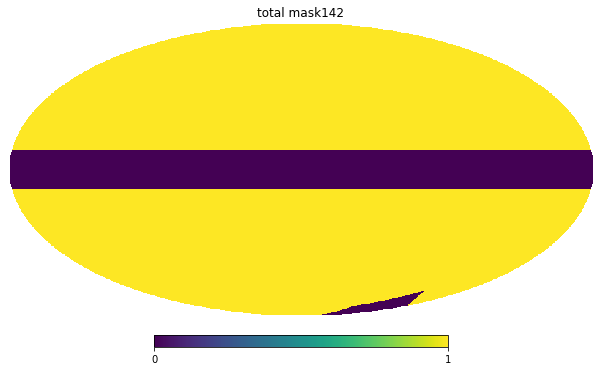

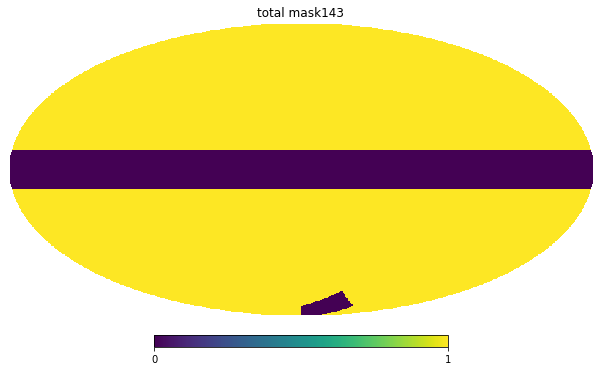

In [5]:
for kk in range(npatches):
    #print(kk)
    jk_mask = jk.get_mask_jk(kk)
    mask_total = mask * jk_mask  #usar essa mascara para calcular a funcao de correlacao
    hp.mollview(mask_total)
    plt.title('total mask'+str(kk))

# Depois que vc armazenar a estatistica (funcao de correlacao, etc) de cada um dos patches, vc pode calcular a covariancia fazendo: 

In [6]:

def get_jk_cov(jk_stats,npatches):
    """
    Get JackKnife covariance and error bar. 
 
    Args:
        jk_stats (array): array with the statistics computed for each JK patch
        npatches (float): number of JK patches 
    """
    mgg  = np.mean(jk_stats, axis =0)
    cov_jk  = np.sum((jk_stats - mgg[None, :])[:, :, None] *
                 (jk_stats - mgg[None, :])[:, None, :], axis=0)
    cov_jk *= ((npatches - 1.)/npatches)  
    sig_jk  = np.sqrt(np.diag(cov_jk))
    return cov_jk, sig_jk


In [9]:
# Total number of patches across the sky.
npatch = hp.nside2npix(nside_jk)
# Resolution of the maps.
nside_maps = hp.npix2nside(len(mask))
# Give each JK region an index.
jk_ids = hp.ud_grade(np.arange(npatch),
                     nside_out=nside_maps).astype(int)
# Number of pixels in each JK region.
npix_per_patch = (nside_maps//nside_jk)**2
ipix = np.arange(hp.nside2npix(nside_maps))

# Loop through available regions and collect only the
# unmasked ones.
# match = esutil.numpy_util.match(np.arange(npatch), jk_ids)
#mask[match[1]] = 

# jk_pixels = []
# for ip in range(npatch):
#     # Compute masked fraction.
#     msk = jk_ids == ip
#     frac = np.sum(mask[msk])/self.npix_per_patch
#     if frac > frac_thr:  # If above threshold, take.
#         jk_pixels.append(ipix[msk])

#         jk_pixels = np.array(jk_pixels)
# # Total number of JK regions.
# npatches = len(self.jk_pixels)


In [12]:
import esutil

In [13]:
match = esutil.numpy_util.match(np.arange(npatch), jk_ids)

In [27]:
match[1]

array([       0,        1,        2, ..., 12582909, 12582910, 12582911])

In [26]:
mask[match[1]]

array([1., 1., 1., ..., 1., 1., 1.])

In [16]:
_, c = np.unique(match[1],return_counts=True)